# 基于ML和DL的股票分析与预测
# # ML and DL based stock analysis and forecasting

## 前置依赖
## predicate dependency

In [1]:
import os
import random
import sys
import warnings

import numpy as np
import pandas as pd
import torch
import seaborn as sns
from matplotlib import pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from statsmodels.tsa.stattools import grangercausalitytests
from torch import nn
from torch.utils.data import Dataset, DataLoader
from tqdm import tqdm
from xgboost import XGBRegressor

In [2]:
warnings.filterwarnings("ignore")  # 忽略警告
plt.rcParams["font.sans-serif"] = ["Microsoft YaHei"]  # 用来正常显示中文标签
plt.rcParams["axes.unicode_minus"] = False  # 用来正常显示负号

## 数据加载及预处理
## Data loading and pre-processing·

### 数据加载
### Data loading

本文使用的数据为S&P 500期货历史数据，数据包含日期、价格（收盘价）、开盘价、最高价、最低价、成交量、涨跌幅等字段，具体日期范围从2015年1月1日至2024年12月10日，数据如下所示：

The data used in this paper is the S&P 500 futures historical data, which contains fields such as date, price (closing price), opening price, high price, low price, volume, gain or loss, etc., and the specific date range is from January 1, 2015 to December 10, 2024, as shown below:

In [3]:
data = pd.read_csv("Apple Stock Price History.csv")  # 加载数据
data["Date"] = pd.to_datetime(data["Date"])  # 转换日期格式
data["Price"] = data["Price"].apply(lambda x: float(str(x).replace(",", "")))  # 转换价格格式
data["Open"] = data["Open"].apply(lambda x: float(str(x).replace(",", "")))  # 转换开盘价格式
data["High"] = data["High"].apply(lambda x: float(str(x).replace(",", "")))  # 转换最高价格式
data["Low"] = data["Low"].apply(lambda x: float(str(x).replace(",", "")))  # 转换最低价格式
data["Vol."] = data["Vol."].apply(
    lambda x: float(str(x).replace("K", "")) * 1000 if "K" in str(x) else float(str(x).replace("M", "")) * 1000000
)  # 转换成交量格式
data["Vol."] = data["Vol."] / 1000000  # 转换成交量单位
data["Change %"] = data["Change %"].apply(lambda x: float(x.replace("%", "")))  # 转换涨跌幅格式
data = data.sort_values(by="Date").reset_index(drop=True)  # 按照日期排序
data = data.fillna(method="ffill").fillna(method="bfill")  # 填充缺失值

data

,Date,Price,Open,High,Low,Vol.,Change %
0,2015-01-02,27.33,27.85,27.86,26.84,212.82,-0.94
1,2015-01-05,26.56,27.07,27.16,26.35,257.14,-2.82
2,2015-01-06,26.57,26.64,26.86,26.16,263.19,0.04
3,2015-01-07,26.94,26.80,27.05,26.67,160.42,1.39
4,2015-01-08,27.97,27.31,28.04,27.18,237.46,3.82
...,...,...,...,...,...,...,...
2498,2024-12-04,243.01,242.87,244.11,241.25,44.38,0.15
2499,2024-12-05,243.04,243.99,244.54,242.13,40.03,0.01
2500,2024-12-06,242.84,242.90,244.63,242.08,36.87,-0.08
2501,2024-12-09,246.75,241.83,247.24,241.75,44.65,1.61


### 数据可视化分析
### Data visualization and analysis

首先，对价格（收盘价）进行可视化分析，绘制收盘价曲线图。

First, the price (closing price) is visualized and analyzed by plotting the closing price graph.

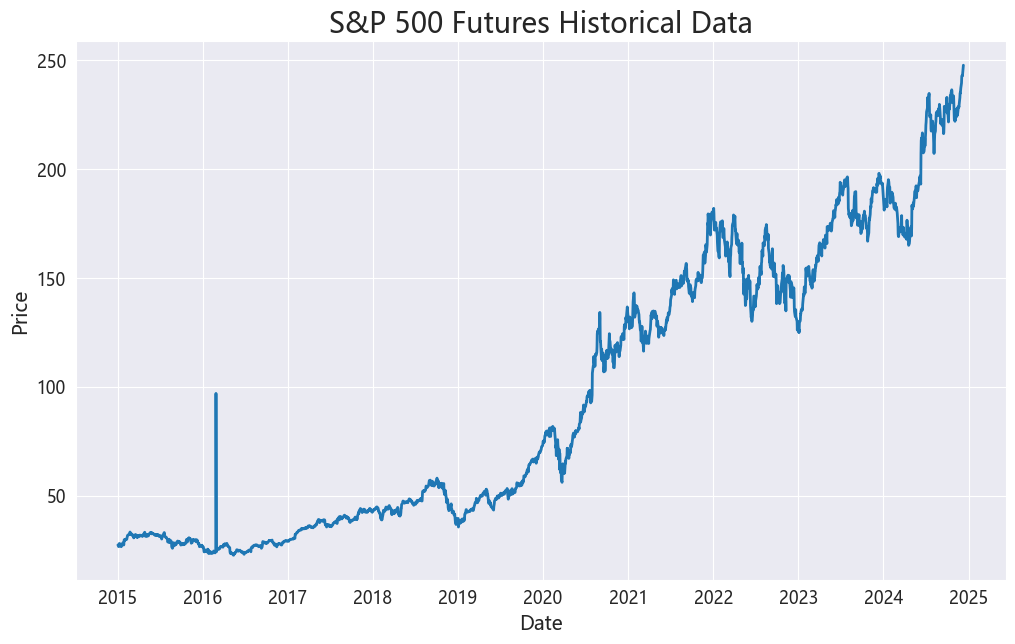

In [4]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(12, 7), dpi=100)  # 定义画布
ax.plot(data["Date"].tolist(), data["Price"].tolist(), marker="", linestyle="-", linewidth=2)  # 画Price曲线
ax.set_title("S&P 500 Futures Historical Data", fontsize=20)  # 标题
ax.set_xlabel("Date", fontsize=14)  # x轴标签
ax.set_ylabel("Price", fontsize=14)  # y轴标签
ax.tick_params(labelsize=12)  # 设置坐标轴轴刻度大小
plt.show()  # 展示图像
plt.close()  # 关闭图像

其次，除价格（收盘价）外，还绘制开盘价、最高价、最低价曲线图。

Second, in addition to the price (closing price), the opening, high and low prices are also plotted.

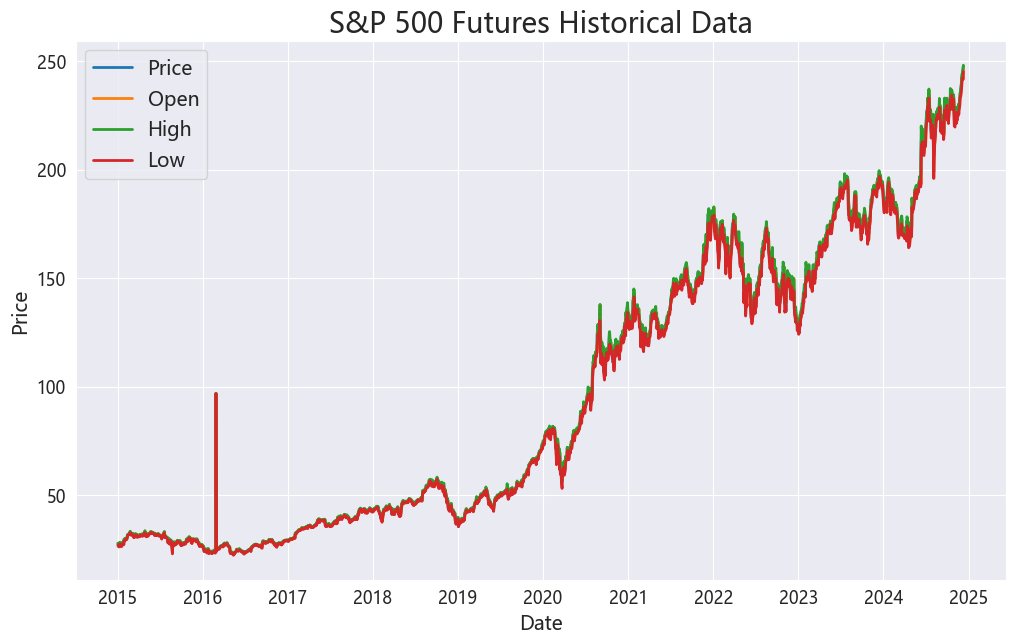

In [5]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(12, 7), dpi=100)  # 定义画布
ax.plot(data["Date"].tolist(), data["Price"].tolist(), marker="", linestyle="-", linewidth=2, label="Price")  # 画Price曲线
ax.plot(data["Date"].tolist(), data["Open"].tolist(), marker="", linestyle="-", linewidth=2, label="Open")  # 画Open曲线
ax.plot(data["Date"].tolist(), data["High"].tolist(), marker="", linestyle="-", linewidth=2, label="High")  # 画High曲线
ax.plot(data["Date"].tolist(), data["Low"].tolist(), marker="", linestyle="-", linewidth=2, label="Low")  # 画Low曲线
ax.set_title("S&P 500 Futures Historical Data", fontsize=20)  # 标题
ax.set_xlabel("Date", fontsize=14)  # x轴标签
ax.set_ylabel("Price", fontsize=14)  # y轴标签
ax.tick_params(labelsize=12)  # 设置坐标轴轴刻度大小
ax.legend(loc="best", prop={"size": 14})  # 图例
plt.show()  # 展示图像
plt.close()  # 关闭图像

接着，绘制成交量曲线图。

Next, plot the volume graph.

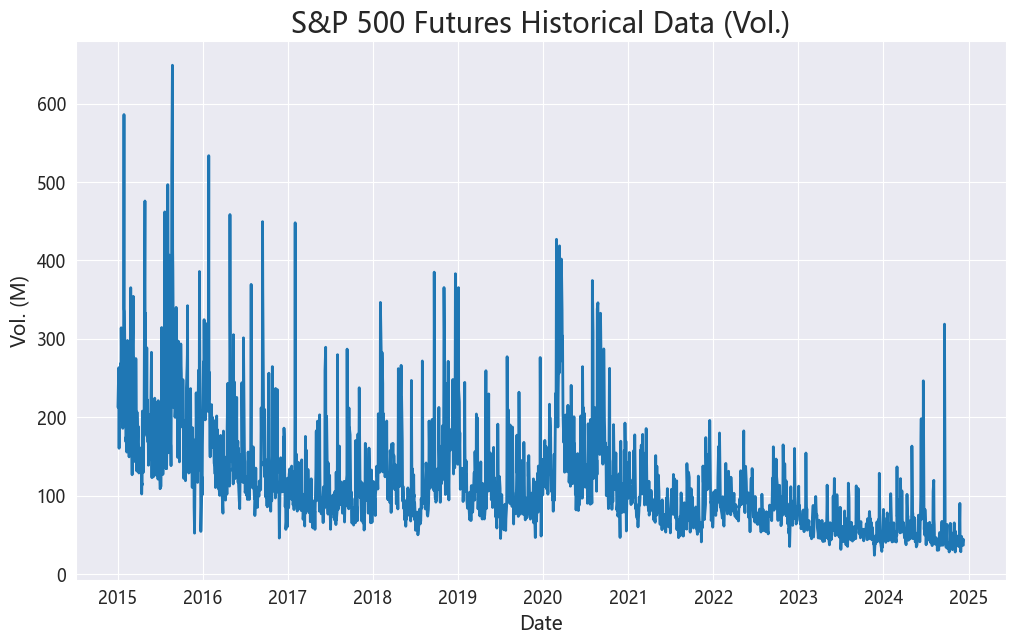

In [6]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(12, 7), dpi=100)  # 定义画布
ax.plot(data["Date"].tolist(), data["Vol."].tolist(), marker="", linestyle="-", linewidth=2)  # 画Price曲线
ax.set_title("S&P 500 Futures Historical Data (Vol.)", fontsize=20)  # 标题
ax.set_xlabel("Date", fontsize=14)  # x轴标签
ax.set_ylabel("Vol. (M)", fontsize=14)  # y轴标签
ax.tick_params(labelsize=12)  # 设置坐标轴轴刻度大小
plt.show()  # 展示图像
plt.close()  # 关闭图像

上述是每日的成交量曲线图，可以看出成交量波动较大，且有明显的峰值。

进一步的，统计每月的平均成交量，绘制成交量每月平均值曲线图。

The above is a graph of the daily volume, which shows that the volume fluctuates and has obvious peaks.

Further, the monthly average volume is counted and the monthly average of the volume is plotted.

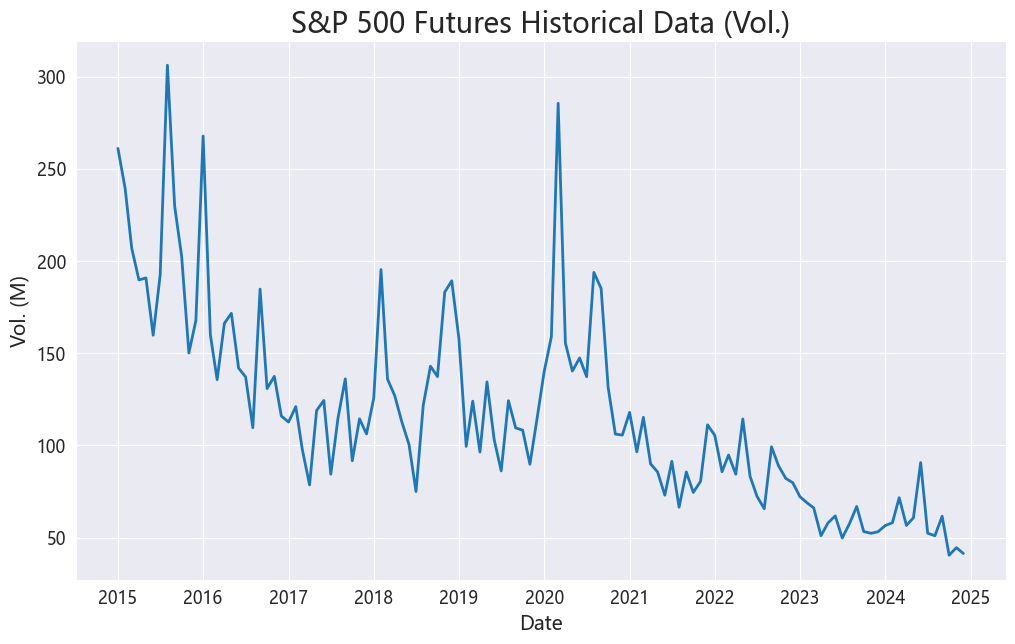

In [7]:
data["Month"] = data["Date"].dt.month  # 提取月份
data["Year"] = data["Date"].dt.year  # 提取年份
data["Month-Year"] = data["Month"].astype(str) + "-" + data["Year"].astype(str)  # 合并月份和年份
data["Month-Year"] = pd.to_datetime(data["Month-Year"], format="%m-%Y")  # 转换日期格式
data_month = data.groupby("Month-Year")["Vol."].mean().reset_index()  # 计算每月平均成交量

del data["Month"], data["Year"], data["Month-Year"]  # 删除中间变量

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(12, 7), dpi=100)  # 定义画布
ax.plot(data_month["Month-Year"].tolist(), data_month["Vol."].tolist(), marker="", linestyle="-", linewidth=2)  # 画Price曲线
ax.set_title("S&P 500 Futures Historical Data (Vol.)", fontsize=20)  # 标题
ax.set_xlabel("Date", fontsize=14)  # x轴标签
ax.set_ylabel("Vol. (M)", fontsize=14)  # y轴标签
ax.tick_params(labelsize=12)  # 设置坐标轴轴刻度大小
plt.show()  # 展示图像
plt.close()  # 关闭图像

最后，绘制价格（收盘价）分布图，其横坐标为价格（收盘价），纵坐标为密度。

Finally, the price (closing price) distribution is plotted with price (closing price) as the horizontal coordinate and density as the vertical coordinate.

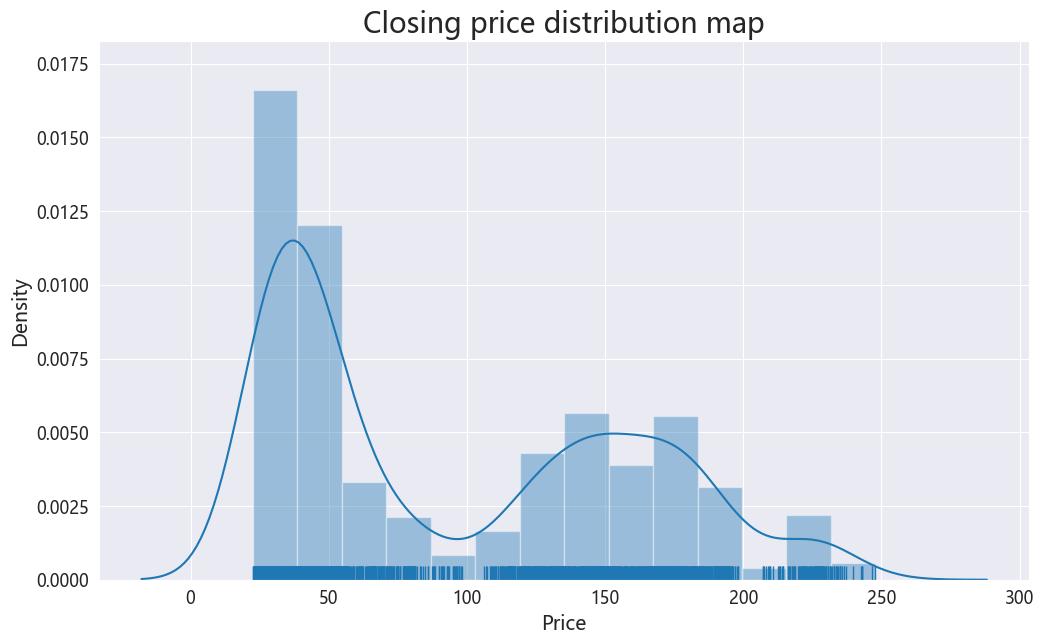

In [8]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(12, 7), dpi=100)  # 定义画布
sns.distplot(data["Price"], rug=True, ax=ax)  # 绘制收盘价分布图
ax.set_title("Closing price distribution map", fontsize=20)  # 标题
ax.set_xlabel("Price", fontsize=14)  # x轴标签
ax.set_ylabel("Density", fontsize=14)  # y轴标签
ax.tick_params(labelsize=12)  # 设置坐标轴轴刻度大小
plt.show()  # 展示图像
plt.close()  # 关闭图像

从价格（收盘价）分布图中可以看出，价格（收盘价）主要分布在2000-3000、4000-5000之间，且密度较高。

除了上述基础的价格、成交量等特征外，为更好的验证开盘价和价格（收盘价）的关系，将绘制开盘价价格（收盘价）的关系图，以开盘价作为横轴，价格（收盘价）作为纵轴，同时进行线性回归拟合。

From the price (closing price) distribution chart, it can be seen that the price (closing price) is mainly distributed between 2000-3000, 4000-5000, and the density is high.

In addition to the above basic price, volume and other characteristics, in order to better verify the relationship between the opening price and price (closing price), the relationship between the opening price price price (closing price) will be plotted, with the opening price as the horizontal axis and the price (closing price) as the vertical axis, and at the same time a linear regression is fitted.

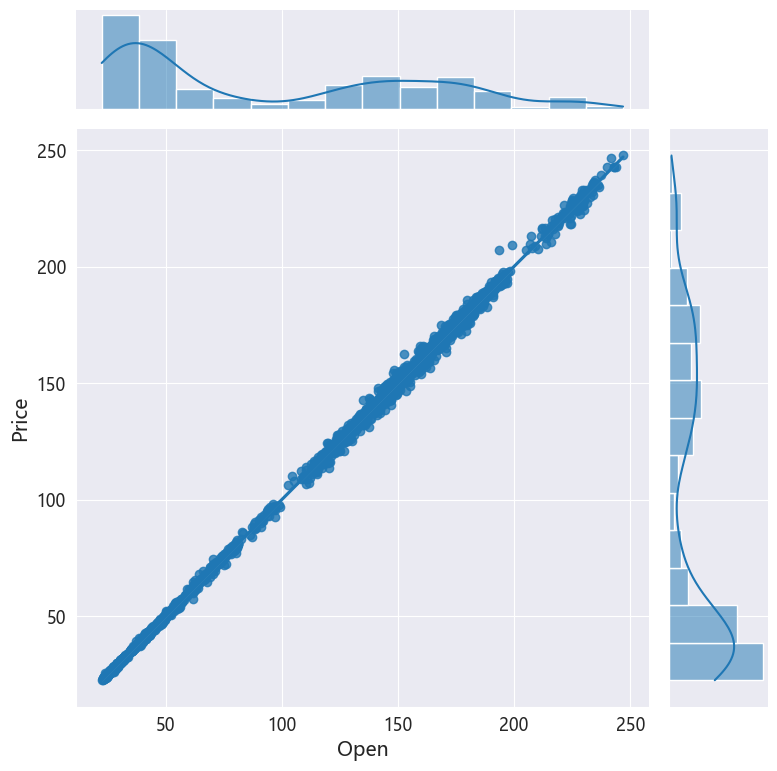

In [9]:
g = sns.jointplot(data=data, x="Open", y="Price", kind="reg")  # 绘制开盘价与收盘价的关系图
g.fig.set_figheight(8)  # 设置图像高度
g.fig.set_figwidth(8)  # 设置图像宽度
# g.fig.suptitle("Relationship between opening price and closing price", fontsize=20)  # 标题
g.set_axis_labels("Open", "Price", fontsize=14)  # 设置坐标轴标签
g.ax_joint.tick_params(labelsize=12)  # 设置坐标轴轴刻度大小
plt.show()  # 展示图像
plt.close()  # 关闭图像

可以发现，开盘价与价格（收盘价）几乎是线性相关的关系，只有极个别的点可能差距过大，说明每天开盘价与价格（收盘价）不会相差太多。

为进一步验证该结论，将绘制开盘价与价格（收盘价）的残差图，即将开盘价与价格（收盘价）的差值进行可视化。

It can be found that the opening price is almost linearly correlated with the price (closing price), with only very few points where the difference may be too large, suggesting that the opening price will not differ too much from the price (closing price) each day.

To further validate the conclusion, a residual plot of the opening price versus the price (closing price) will be plotted, i.e., the difference between the opening price and the price (closing price) will be visualized.

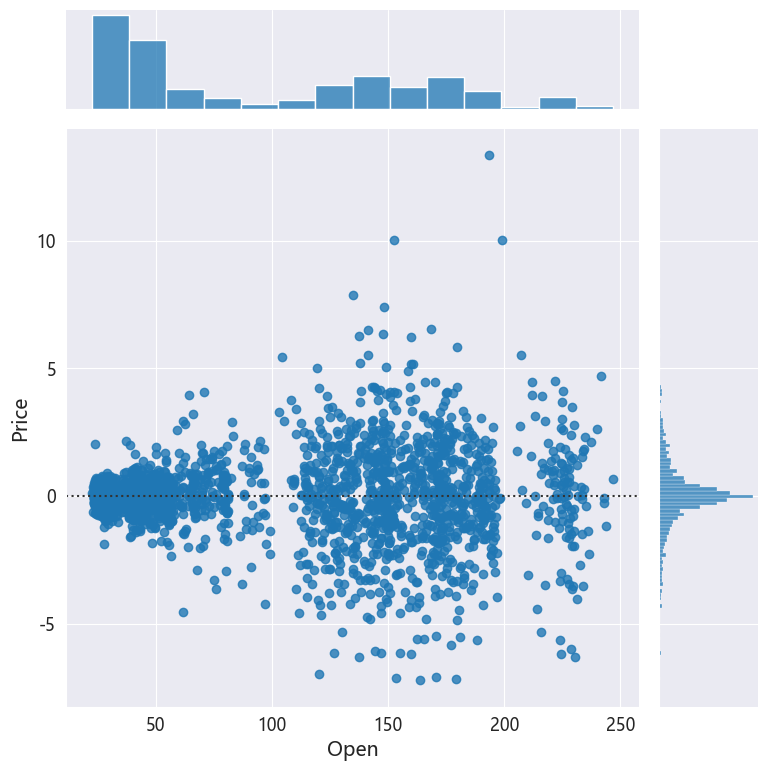

In [10]:
g = sns.jointplot(data=data, x="Open", y="Price", kind="resid")  # 绘制开盘价与收盘价的残差图
g.fig.set_figheight(8)  # 设置图像高度
g.fig.set_figwidth(8)  # 设置图像宽度
# g.fig.suptitle("Residual map of opening price and closing price", fontsize=20)  # 标题
g.set_axis_labels("Open", "Price", fontsize=14)  # 设置坐标轴标签
g.ax_joint.tick_params(labelsize=12)  # 设置坐标轴轴刻度大小
plt.show()  # 展示图像
plt.close()  # 关闭图像

可以发现，每天的开盘价与价格（收盘价）之间的差距大多在±100之间，除了极个别的特殊情况外，不会波动太大。

接下来，进行多变量分析。将开盘价、价格（收盘价）、最低价、最高价、交易量等绘制多变量相关性关系图。

It can be noticed that most of the daily gap between the opening price and the price (closing price) is between ±100, which does not fluctuate too much except for very few special cases.

Next, a multivariate analysis is performed. Multivariate correlations are plotted for opening price, price (closing price), minimum price, maximum price, and trading volume.


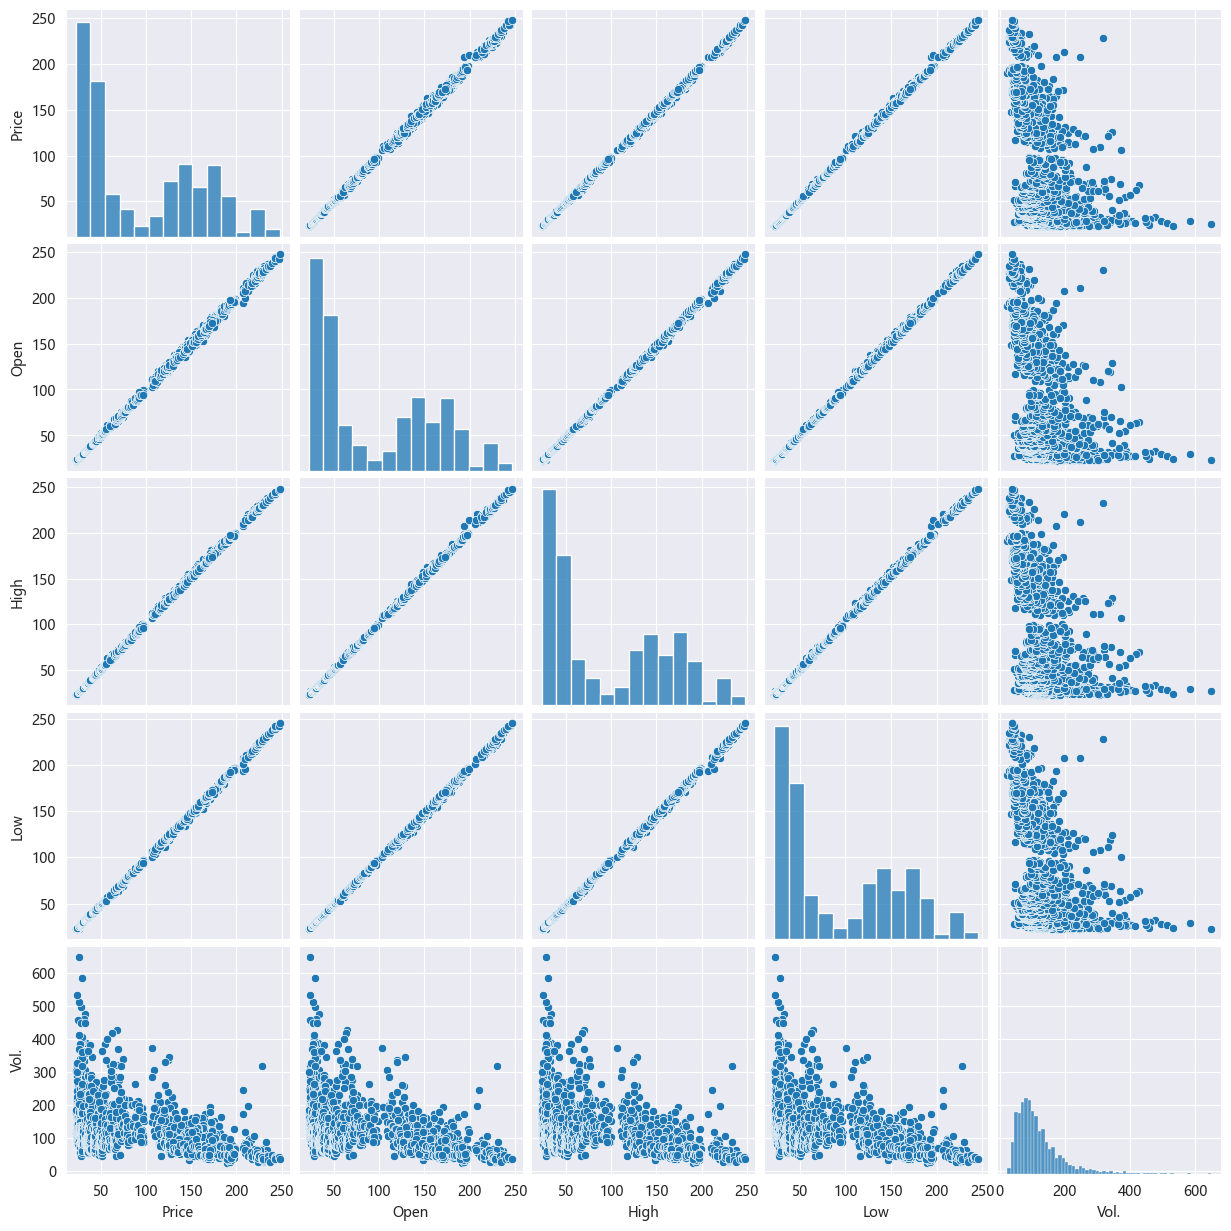

In [11]:
sns.pairplot(data=data, vars=["Price", "Open", "High", "Low", "Vol."])  # 绘制散点图矩阵
plt.show()  # 显示图像
plt.close()  # 关闭图像

上述图是直接调用sns.pairplot()函数实现的，可以发现是一个对称三角矩阵图，即左下角与右上角的图是完全一样的。

当然，可以通过更复杂的形式实现，查看seaborn源码可以发现，其绘图接口大多依赖于一个类实现。例如：jointplot在seaborn中实际上先实现了一个名为JointGrid的类，然后在调用jointplot时即是调用该类实现。相比之下，JointGrid可以实现更为丰富的可定制绘图接口，而jointplot则是其一个简单的样例实现。类似地，pairplot则是依赖于PairGrid类实现。

接下来，调用了PairGrid类实现，与标准pairplot不同的是上三角子图选用了kde图表，效果更为丰富。

The above plot is realized by directly calling the sns.pairplot() function, which can be found to be a symmetric triangular matrix plot, i.e., the bottom-left corner and the top-right corner of the plot are exactly the same.

Of course, can be achieved through a more complex form , view seaborn source code can be found , most of its plotting interface depends on a class implementation. For example: jointplot in seaborn actually first implemented a class called JointGrid, and then in the call jointplot is to call the class implementation. In contrast, JointGrid allows for a much richer customizable drawing interface, while jointplot is a simple sample implementation. Similarly, pairplot relies on the PairGrid class implementation.

Next, the PairGrid class implementation is called, which differs from the standard pairplot by the choice of a kde chart for the upper triangle subplot, for a richer effect.

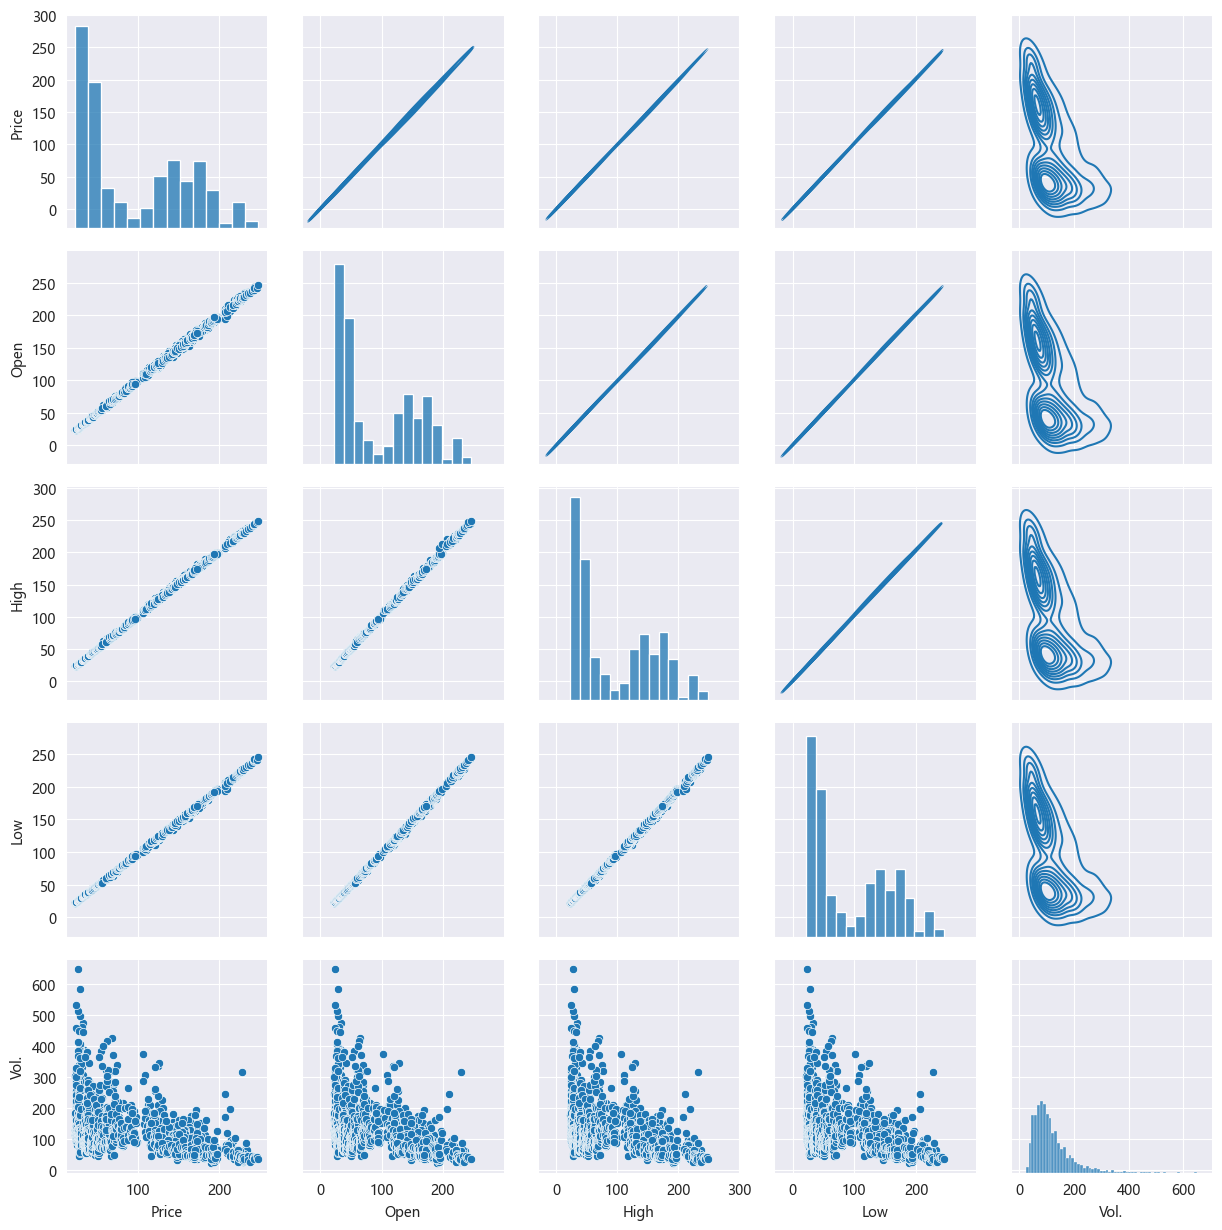

In [12]:
pg = sns.PairGrid(data=data, vars=["Price", "Open", "High", "Low", "Vol."])  # 绘制散点图矩阵
pg.map_diag(sns.histplot)  # 绘制直方图
pg.map_lower(sns.scatterplot)  # 绘制散点图
pg.map_upper(sns.kdeplot)  # 绘制核密度图
plt.show()  # 显示图像
plt.close()  # 关闭图像

最后，对数据计算皮尔逊相关系数，并进行热力图展示。

Finally, Pearson correlation coefficients were calculated for the data and heat maps were presented.

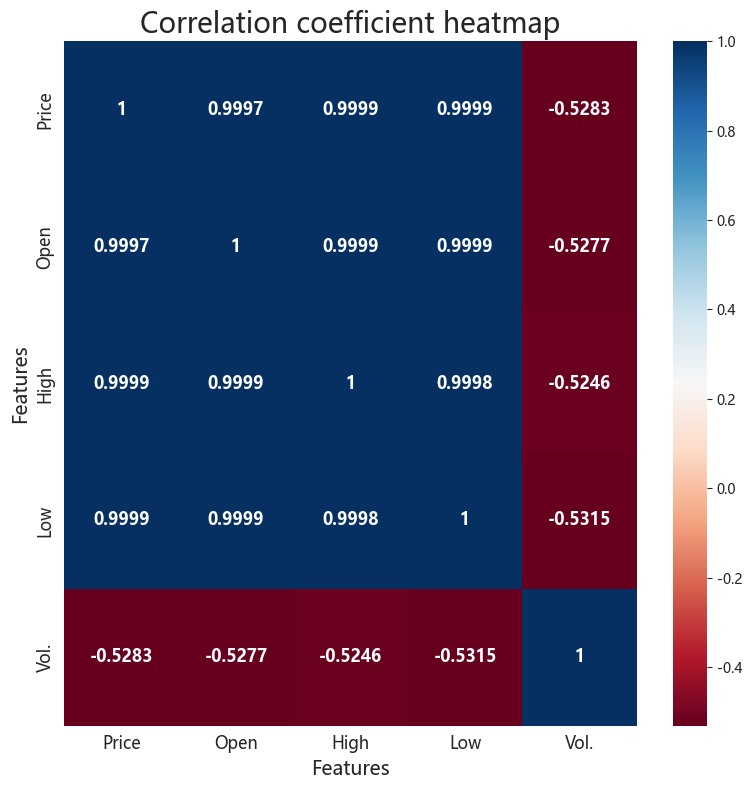

In [13]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(8, 8), dpi=100)  # 定义画布
sns.heatmap(
    data[["Price", "Open", "High", "Low", "Vol."]].corr(),
    annot=True,
    fmt=".4g",
    cmap="RdBu",  # Blues
    annot_kws={"size": 12, "weight": "bold"},
    ax=ax,
)  # 绘制相关性图
ax.set_title("Correlation coefficient heatmap", fontsize=20)  # 标题
ax.set_xlabel("Features", fontsize=14)  # x轴标签
ax.set_ylabel("Features", fontsize=14)  # y轴标签
ax.tick_params(labelsize=12)  # 设置坐标轴轴刻度大小
plt.tight_layout()  # 防重叠
plt.show()  # 显示图像
plt.close()  # 关闭图像

可以看出，开盘价与最高价的相关性最高，价格（收盘价）也与最高价的相关性最高，另外，不管是开盘价、价格（收盘价）、最低价、最高价，都与交易量呈负相关，且相关性基本都在-0.37左右。

It can be seen that the opening price has the highest correlation with the highest price, and the price (closing price) also has the highest correlation with the highest price, in addition, no matter the opening price, the price (closing price), the lowest price, the highest price, are negatively correlated with the trading volume, and the correlation is basically around -0.37.

进一步的，对数据进行描述性统计。

Further, descriptive statistics were performed on the data.

In [14]:
data.describe()  # 描述性统计

,Date,Price,Open,High,Low,Vol.,Change %
count,2503,2503.000000,2503.000000,2503.000000,2503.000000,2503.000000,2503.000000
mean,2019-12-21 01:51:36.604075008,95.492861,95.408122,96.423324,94.461019,117.527483,0.193867
min,2015-01-02 00:00:00,22.590000,22.500000,22.920000,22.370000,24.050000,-75.070000
25%,2017-06-26 12:00:00,37.565000,37.490000,37.915000,37.195000,71.415000,-0.740000
50%,2019-12-19 00:00:00,66.120000,65.940000,66.790000,65.310000,100.590000,0.090000
75%,2022-06-14 12:00:00,151.745000,151.430000,153.655000,150.080000,142.920000,1.010000
max,2024-12-10 00:00:00,247.770000,246.890000,248.210000,245.340000,648.830000,300.120000
std,NaN,64.371717,64.299074,64.966116,63.690493,68.377567,6.438351


### 构建样本
### Constructing samples

In [15]:
windows = 30  # 时间窗口大小 历史一个月的数据
feature_columns = ["Price", "Open", "High", "Low", "Vol.", "Change %"]  # 特征列
target_columns = ["Price"]  # 目标列

X = []  # 输入
y = []  # 输出
for idx in range(windows, len(data)):  # 滑动窗口
    X.append(data[feature_columns].iloc[idx - windows:idx].values.tolist())  # 构建输入
    y.append(data[target_columns].iloc[idx].values.tolist())  # 构建输出

X = np.array(X)  # 转换为numpy数组
y = np.array(y)  # 转换为numpy数组
print(f"X shape: {X.shape}, y shape: {y.shape}")  # 打印维度

X shape: (2473, 30, 6), y shape: (2473, 1)


### 切分数据集
### Slicing the data set

In [16]:
X_train, X_test, y_train, y_test, date_train, date_test = train_test_split(
    X,
    y,
    data["Date"].iloc[windows:],
    test_size=0.2,
    random_state=42,
    shuffle=False,
)  # 划分训练集和测试集

print(f"X_train shape: {X_train.shape}, y_train shape: {y_train.shape}")  # 打印训练集维度
print(f"X_test shape: {X_test.shape}, y_test shape: {y_test.shape}")  # 打印测试集维度

X_train shape: (1978, 30, 6), y_train shape: (1978, 1)
X_test shape: (495, 30, 6), y_test shape: (495, 1)


### 数据标准化
### Standardization of data

In [17]:
X_scaler = StandardScaler()  # 定义标准化模型
X_train = X_scaler.fit_transform(X_train.reshape(X_train.shape[0] * X_train.shape[1], X_train.shape[2])).reshape(
    X_train.shape[0], X_train.shape[1], X_train.shape[2]
)  # 训练集标准化
X_test = X_scaler.transform(X_test.reshape(X_test.shape[0] * X_test.shape[1], X_test.shape[2])).reshape(
    X_test.shape[0], X_test.shape[1], X_test.shape[2]
)  # 测试集标准化

In [18]:
y_scaler = StandardScaler()  # 定义标准化模型
y_train = y_scaler.fit_transform(y_train)  # 训练集标准化
y_test = y_scaler.transform(y_test)  # 测试集标准化

## 模型训练及评估
## Model training and evaluation

### LR模型训练及评估
### LR model training and evaluation

In [19]:
lr_model = LinearRegression()  # 定义LR模型
lr_model.fit(X_train.reshape(X_train.shape[0], -1), y_train.reshape(-1))  # 训练模型

LinearRegression()

In [20]:
y_test_pred_of_lr = lr_model.predict(X_test.reshape(X_test.shape[0], -1))  # 预测测试集数值

y_train_of_lr = y_scaler.inverse_transform(y_train.reshape(-1, 1)).reshape(-1).tolist()  # 反标准化
y_test_of_lr = y_scaler.inverse_transform(y_test.reshape(-1, 1)).reshape(-1).tolist()  # 反标准化
y_test_pred_of_lr = y_scaler.inverse_transform(y_test_pred_of_lr.reshape(-1, 1)).reshape(-1).tolist()  # 反标准化

print("LR Model:")
print(f"MAE: {mean_absolute_error(y_test_of_lr, y_test_pred_of_lr)}")  # 平均绝对误差
print(f"MSE: {mean_squared_error(y_test_of_lr, y_test_pred_of_lr)}")  # 均方误差
print(f"RMSE: {mean_squared_error(y_test_of_lr, y_test_pred_of_lr, squared=False)}")  # 均方根误差
print(f"R2: {r2_score(y_test_of_lr, y_test_pred_of_lr)}")  # R2

LR Model:
MAE: 2.1759577290211984
MSE: 8.51183371231164
RMSE: 2.9175047064763477
R2: 0.9881533692725252


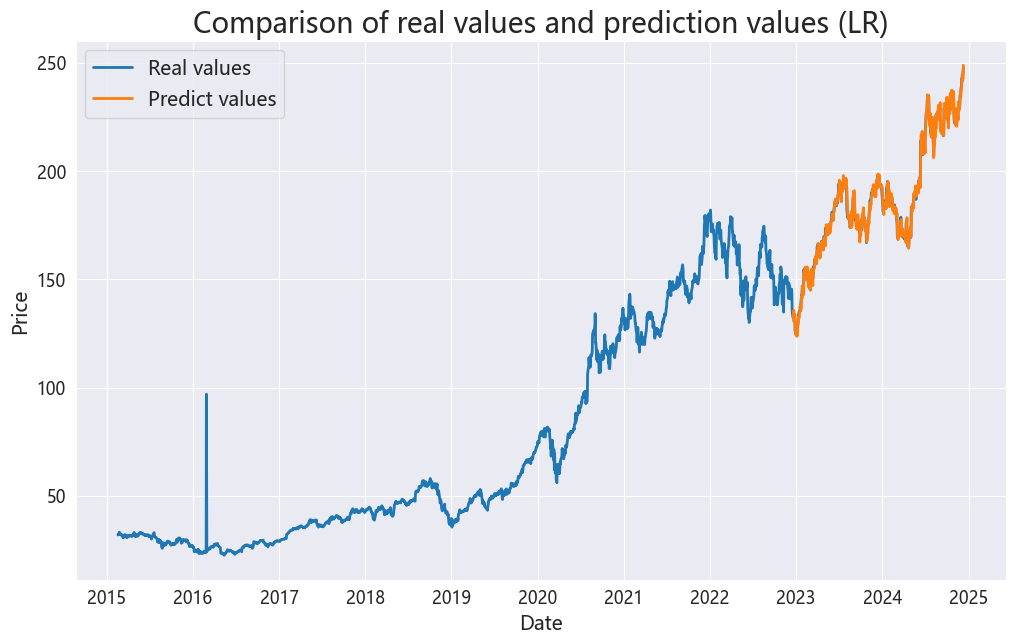

In [21]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(12, 7), dpi=100)  # 定义画布
ax.plot(
    date_train.tolist() + date_test.tolist(),
    y_train_of_lr + y_test_of_lr,
    marker="",
    linestyle="-",
    linewidth=2,
    label="Real values",
)  # 画真实值
ax.plot(date_test, y_test_pred_of_lr, marker="", linestyle="-", linewidth=2, label="Predict values")  # 画预测值
ax.set_title("Comparison of real values and prediction values (LR)", fontsize=20)  # 标题
ax.set_xlabel("Date", fontsize=14)  # x轴标签
ax.set_ylabel("Price", fontsize=14)  # y轴标签
ax.tick_params(labelsize=12)  # 设置坐标轴轴刻度大小
ax.legend(loc="best", prop={"size": 14})  # 图例
plt.show()  # 显示图像
plt.close()  # 关闭图像

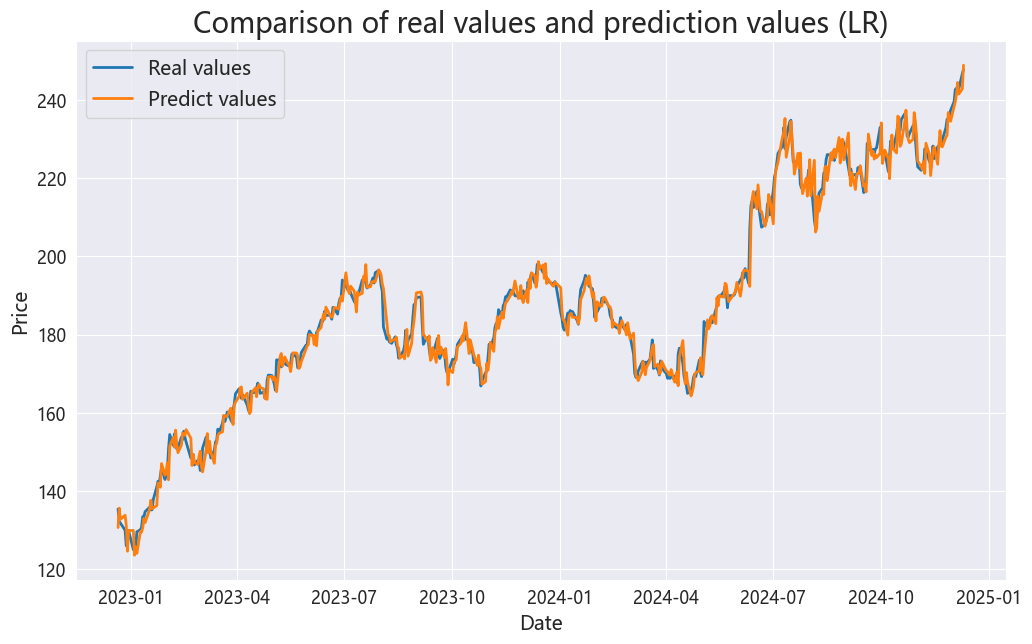

In [22]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(12, 7), dpi=100)  # 定义画布
ax.plot(date_test, y_test_of_lr, marker="", linestyle="-", linewidth=2, label="Real values")  # 画真实值
ax.plot(date_test, y_test_pred_of_lr, marker="", linestyle="-", linewidth=2, label="Predict values")  # 画预测值
ax.set_title("Comparison of real values and prediction values (LR)", fontsize=20)  # 标题
ax.set_xlabel("Date", fontsize=14)  # x轴标签
ax.set_ylabel("Price", fontsize=14)  # y轴标签
ax.tick_params(labelsize=12)  # 设置坐标轴轴刻度大小
ax.legend(loc="best", prop={"size": 14})  # 图例
plt.show()  # 显示图像
plt.close()  # 关闭图像

### XGBoost模型训练及评估
### XGBoost model training and evaluation

In [23]:
xgb_model = XGBRegressor(random_state=42)  # 定义XGBoost模型
xgb_model.fit(X_train.reshape(X_train.shape[0], -1), y_train.reshape(-1))  # 训练模型

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=100, n_jobs=None, num_parallel_tree=None,
             predictor=None, random_state=42, ...)

In [24]:
y_test_pred_of_xgb = xgb_model.predict(X_test.reshape(X_test.shape[0], -1))  # 预测测试集数值

y_train_of_xgb = y_scaler.inverse_transform(y_train.reshape(-1, 1)).reshape(-1).tolist()  # 反标准化
y_test_of_xgb = y_scaler.inverse_transform(y_test.reshape(-1, 1)).reshape(-1).tolist()  # 反标准化
y_test_pred_of_xgb = y_scaler.inverse_transform(y_test_pred_of_xgb.reshape(-1, 1)).reshape(-1).tolist()  # 反标准化

print("XGBoost Model:")
print(f"MAE: {mean_absolute_error(y_test_of_xgb, y_test_pred_of_xgb)}")  # 平均绝对误差
print(f"MSE: {mean_squared_error(y_test_of_xgb, y_test_pred_of_xgb)}")  # 均方误差
print(f"RMSE: {mean_squared_error(y_test_of_xgb, y_test_pred_of_xgb, squared=False)}")  # 均方根误差
print(f"R2: {r2_score(y_test_of_xgb, y_test_pred_of_xgb)}")  # R2

XGBoost Model:
MAE: 20.61825204128689
MSE: 869.9841719035174
RMSE: 29.495494094920964
R2: -0.21082971914519666


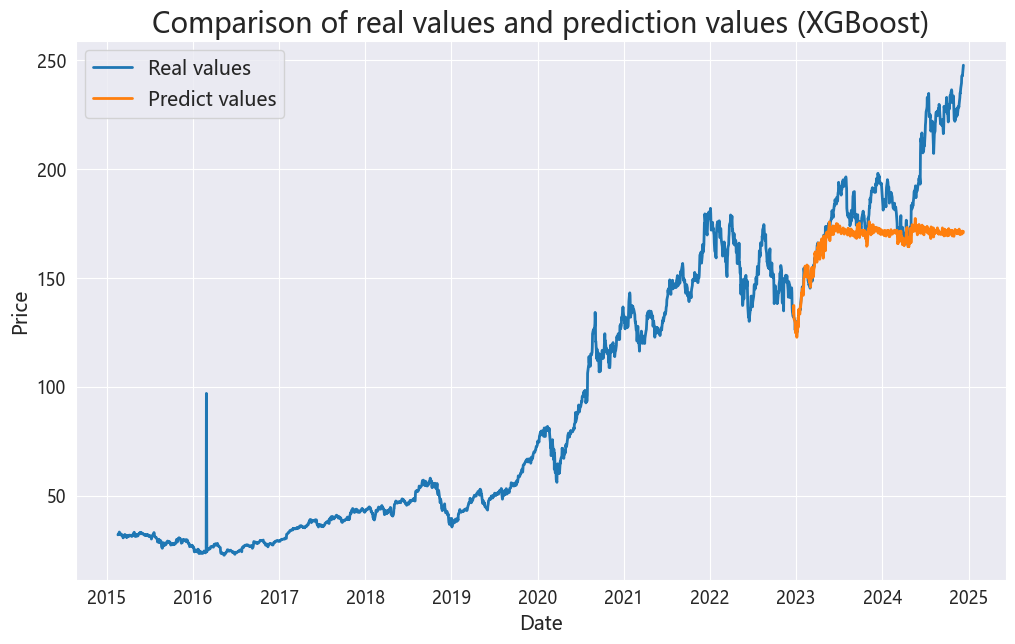

In [25]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(12, 7), dpi=100)  # 定义画布
ax.plot(
    date_train.tolist() + date_test.tolist(),
    y_train_of_xgb + y_test_of_xgb,
    marker="",
    linestyle="-",
    linewidth=2,
    label="Real values",
)  # 画真实值
ax.plot(date_test, y_test_pred_of_xgb, marker="", linestyle="-", linewidth=2, label="Predict values")  # 画预测值
ax.set_title("Comparison of real values and prediction values (XGBoost)", fontsize=20)  # 标题
ax.set_xlabel("Date", fontsize=14)  # x轴标签
ax.set_ylabel("Price", fontsize=14)  # y轴标签
ax.tick_params(labelsize=12)  # 设置坐标轴轴刻度大小
ax.legend(loc="best", prop={"size": 14})  # 图例
plt.show()  # 显示图像
plt.close()  # 关闭图像

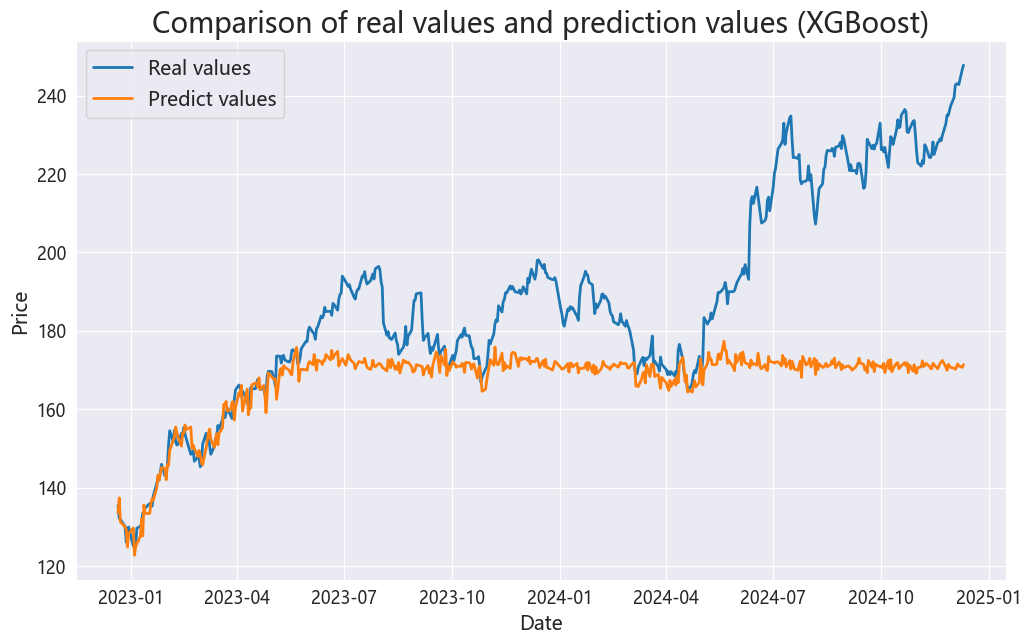

In [26]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(12, 7), dpi=100)  # 定义画布
ax.plot(date_test, y_test_of_xgb, marker="", linestyle="-", linewidth=2, label="Real values")  # 画真实值
ax.plot(date_test, y_test_pred_of_xgb, marker="", linestyle="-", linewidth=2, label="Predict values")  # 画预测值
ax.set_title("Comparison of real values and prediction values (XGBoost)", fontsize=20)  # 标题
ax.set_xlabel("Date", fontsize=14)  # x轴标签
ax.set_ylabel("Price", fontsize=14)  # y轴标签
ax.tick_params(labelsize=12)  # 设置坐标轴轴刻度大小
ax.legend(loc="best", prop={"size": 14})  # 图例
plt.show()  # 显示图像
plt.close()  # 关闭图像

### LSTM模型训练及评估
### LSTM model training and evaluation

In [27]:
def setup_seed(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    os.environ["PYTHONHASHSEED"] = str(seed)

    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)

    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    torch.backends.cudnn.enabled = False

    os.environ["CUBLAS_WORKSPACE_CONFIG"] = ":16:8"

    torch.use_deterministic_algorithms(True)

setup_seed(seed=42)  # 设置随机种子

In [28]:
class Datasets(Dataset):
    def __init__(self, X, y):
        self.X = X
        self.y = y

    def __len__(self):
        assert len(self.X) == len(self.y)
        return len(self.y)

    def __getitem__(self, index):
        return torch.FloatTensor(self.X[index]), torch.FloatTensor(self.y[index])

In [29]:
class LSTMModel(nn.Module):
    def __init__(self, inputs_size, outputs_size):
        super(LSTMModel, self).__init__()
        self.up_dim = nn.Linear(inputs_size, 32)  # 升维层
        self.lstm = nn.LSTM(32, 128, num_layers=1, batch_first=True, dropout=0, bidirectional=False)  # LSTM层
        self.predict = nn.Linear(128, outputs_size)  # 预测层
        self.activation = nn.PReLU()  # 激活层
        self.dropout = nn.Dropout(0.2)  # dropout层

    def lstm_forward(self, inputs):  # torch.Size([B, W, 32])
        outputs, (h_n, c_n) = self.lstm(inputs)  # torch.Size([B, W, 128])
        outputs = outputs[:, -1, :]  # torch.Size([B, 128])
        outputs = self.activation(outputs)  # torch.Size([B, 128])
        return outputs

    def forward(self, inputs):  # torch.Size([B, W, T])
        outputs = self.up_dim(inputs)  # torch.Size([B, W, 32])
        outputs = self.lstm_forward(outputs)  # torch.Size([B, 128])

        outputs = self.dropout(outputs)  # torch.Size([B, 128])
        outputs = self.predict(outputs)  # torch.Size([B, 1])
        return outputs

In [30]:
batch_size = 128  # 批次大小
epochs = 200  # 训练轮数
learning_rate = 0.0003  # 学习率
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")  # 设备

print("Device:", device)  # 打印设备

Device: cuda


In [31]:
train_datasets = Datasets(X_train, y_train)  # 训练集
test_datasets = Datasets(X_test, y_test)  # 测试集

train_loader = DataLoader(train_datasets, batch_size=batch_size, shuffle=True, num_workers=0, drop_last=False)  # 训练集加载器
test_loader = DataLoader(test_datasets, batch_size=batch_size, shuffle=False, num_workers=0, drop_last=False)  # 测试集加载器

In [32]:
lstm_model = LSTMModel(inputs_size=X_train.shape[-1], outputs_size=1).to(device)  # 定义模型
optimizer = torch.optim.Adam(lstm_model.parameters(), lr=learning_rate)  # 优化器
criterion = torch.nn.MSELoss()  # 损失函数

In [33]:
best_test_r2 = 0  # 最好的测试集R2
train_r2_records = []  # 训练集R2记录
train_loss_records = []  # 训练集Loss记录
test_r2_records = []  # 测试集R2记录
test_loss_records = []  # 测试集Loss记录
for epoch in range(1, epochs + 1):  # 循环每一个epoch
    lstm_model.train()  # 训练模式
    train_real_targets = []  # 训练集真实值
    train_pred_targets = []  # 训练集预测值
    train_loss_logs = []  # 训练集Loss记录
    for inputs, targets in tqdm(train_loader, file=sys.stdout):  # 循环每一个batch
        outputs = lstm_model(inputs.to(device))  # 前向传播
        loss = criterion(outputs, targets.to(device))  # 计算Loss
        optimizer.zero_grad()  # 梯度清零
        loss.backward()  # 反向传播
        optimizer.step()  # 更新参数
        train_real_targets.extend(targets.numpy().tolist())  # 记录真实值
        train_pred_targets.extend(outputs.detach().cpu().numpy().tolist())  # 记录预测值
        train_loss_logs.append(loss.item())  # 记录Loss
    train_r2 = round(r2_score(train_real_targets, train_pred_targets), 4)  # 计算R2
    train_loss = round(sum(train_loss_logs) / len(train_loss_logs), 4)  # 求loss均值
    print(f"Epoch: {epoch} / {epochs}, Train R2: {train_r2:.4f}, Train Loss: {train_loss:4f}")

    lstm_model.eval()  # 测试模式
    test_real_targets = []  # 测试集真实值
    test_pred_targets = []  # 测试集预测值
    test_loss_logs = []  # 测试集Loss记录
    for inputs, targets in tqdm(test_loader, file=sys.stdout):  # 循环每一个batch
        outputs = lstm_model(inputs.to(device))  # 前向传播
        loss = criterion(outputs, targets.to(device))  # 计算Loss
        test_real_targets.extend(targets.numpy().tolist())  # 记录真实值
        test_pred_targets.extend(outputs.detach().cpu().numpy().tolist())  # 记录预测值
        test_loss_logs.append(loss.item())  # 记录Loss
    test_r2 = round(r2_score(test_real_targets, test_pred_targets), 4)  # 计算R2
    test_loss = round(sum(test_loss_logs) / len(test_loss_logs), 4)  # 求loss均值
    print(f"Epoch: {epoch} / {epochs}, Test R2: {test_r2}, Test Loss: {test_loss}")

    if test_r2 > best_test_r2:  # 保存最好的模型
        best_test_r2 = test_r2  # 更新最好的测试集R2
        torch.save(lstm_model.state_dict(), "lstm_model.pt")  # 保存模型
    print(f"Best test r2: {best_test_r2:.4f}")

    train_r2_records.append(train_r2)  # 记录训练集R2
    train_loss_records.append(train_loss)  # 记录训练集Loss
    test_r2_records.append(test_r2)  # 记录测试集R2
    test_loss_records.append(test_loss)  # 记录测试集Loss

print("Done! Best test r2:", best_test_r2)

100%|██████████| 16/16 [00:00<00:00, 19.80it/s]
Epoch: 1 / 200, Train R2: 0.2300, Train Loss: 0.759600
100%|██████████| 4/4 [00:00<00:00, 299.22it/s]
Epoch: 1 / 200, Test R2: -7.6831, Test Loss: 2.6696
Best test r2: 0.0000
100%|██████████| 16/16 [00:00<00:00, 106.78it/s]
Epoch: 2 / 200, Train R2: 0.7537, Train Loss: 0.240300
100%|██████████| 4/4 [00:00<00:00, 266.37it/s]
Epoch: 2 / 200, Test R2: 0.1009, Test Loss: 0.2904
Best test r2: 0.1009
100%|██████████| 16/16 [00:00<00:00, 112.65it/s]
Epoch: 3 / 200, Train R2: 0.9586, Train Loss: 0.041100
100%|██████████| 4/4 [00:00<00:00, 363.95it/s]
Epoch: 3 / 200, Test R2: -0.5691, Test Loss: 0.4993
Best test r2: 0.1009
100%|██████████| 16/16 [00:00<00:00, 110.87it/s]
Epoch: 4 / 200, Train R2: 0.9783, Train Loss: 0.021400
100%|██████████| 4/4 [00:00<00:00, 335.27it/s]
Epoch: 4 / 200, Test R2: -0.3562, Test Loss: 0.4324
Best test r2: 0.1009
100%|██████████| 16/16 [00:00<00:00, 113.47it/s]
Epoch: 5 / 200, Train R2: 0.9818, Train Loss: 0.018200
10

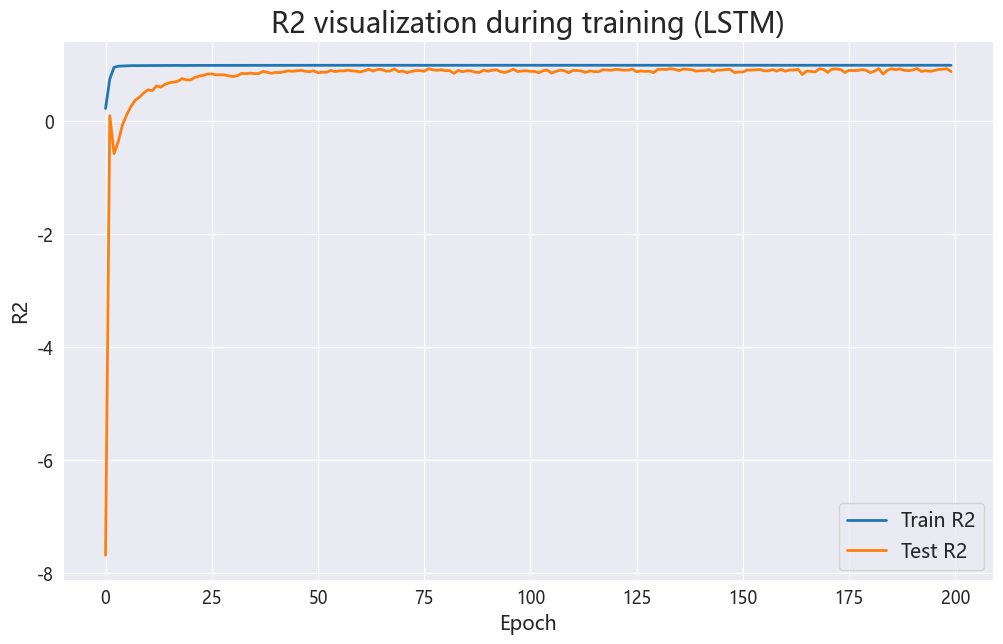

In [34]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(12, 7), dpi=100)  # 定义画布
ax.plot(train_r2_records, marker="", linestyle="-", linewidth=2, label="Train R2")  # 画训练集R2曲线
ax.plot(test_r2_records, marker="", linestyle="-", linewidth=2, label="Test R2")  # 画测试集R2曲线
ax.set_title("R2 visualization during training (LSTM)", fontsize=20)  # 标题
ax.set_xlabel("Epoch", fontsize=14)  # x轴标签
ax.set_ylabel("R2", fontsize=14)  # y轴标签
ax.tick_params(labelsize=12)  # 设置坐标轴轴刻度大小
ax.legend(loc="best", prop={"size": 14})  # 图例
plt.show()  # 显示图像
plt.close()  # 关闭图像

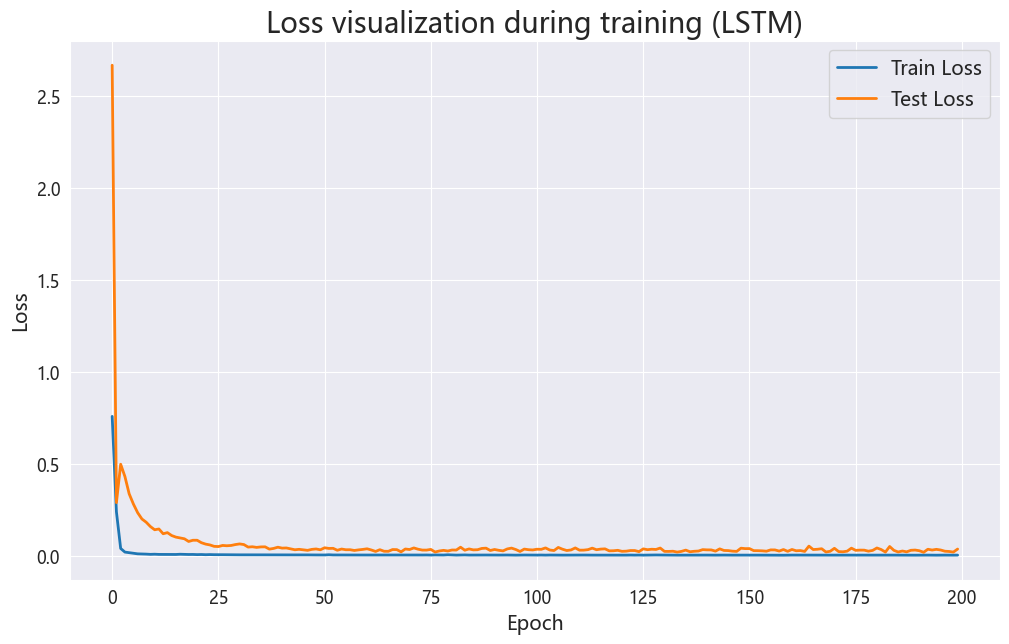

In [35]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(12, 7), dpi=100)  # 定义画布
ax.plot(train_loss_records, marker="", linestyle="-", linewidth=2, label="Train Loss")  # 画训练集Loss曲线
ax.plot(test_loss_records, marker="", linestyle="-", linewidth=2, label="Test Loss")  # 画测试集Loss曲线
ax.set_title("Loss visualization during training (LSTM)", fontsize=20)  # 标题
ax.set_xlabel("Epoch", fontsize=14)  # x轴标签
ax.set_ylabel("Loss", fontsize=14)  # y轴标签
ax.tick_params(labelsize=12)  # 设置坐标轴轴刻度大小
ax.legend(loc="best", prop={"size": 14})  # 图例
plt.show()  # 显示图像
plt.close()  # 关闭图像

In [36]:
lstm_model = LSTMModel(inputs_size=X_train.shape[-1], outputs_size=1).to(device)  # 定义模型
lstm_model.load_state_dict(torch.load("lstm_model.pt"))  # 加载模型
lstm_model.eval()  # 测试模式

y_test_pred_of_lstm = []  # 测试集预测值
for inputs, targets in tqdm(test_loader, file=sys.stdout):  # 循环每一个batch
    outputs = lstm_model(inputs.to(device))  # 前向传播
    y_test_pred_of_lstm.extend(outputs.detach().cpu().numpy().tolist())  # 记录预测值

y_train_of_lstm = y_scaler.inverse_transform(y_train.reshape(-1, 1)).reshape(-1).tolist()  # 反标准化
y_test_of_lstm = y_scaler.inverse_transform(y_test.reshape(-1, 1)).reshape(-1).tolist()  # 反标准化
y_test_pred_of_lstm = y_scaler.inverse_transform(y_test_pred_of_lstm).reshape(-1).tolist()  # 反标准化

print("LSTM Model:")
print(f"MAE: {mean_absolute_error(y_test_of_lstm, y_test_pred_of_lstm)}")  # 平均绝对误差
print(f"MSE: {mean_squared_error(y_test_of_lstm, y_test_pred_of_lstm)}")  # 均方误差
print(f"RMSE: {mean_squared_error(y_test_of_lstm, y_test_pred_of_lstm, squared=False)}")  # 均方根误差
print(f"R2: {r2_score(y_test_of_lstm, y_test_pred_of_lstm)}")  # R2

100%|██████████| 4/4 [00:00<00:00, 213.88it/s]
LSTM Model:
MAE: 4.495616363655352
MSE: 44.930231912001624
RMSE: 6.703001709085387
R2: 0.9374668392321386


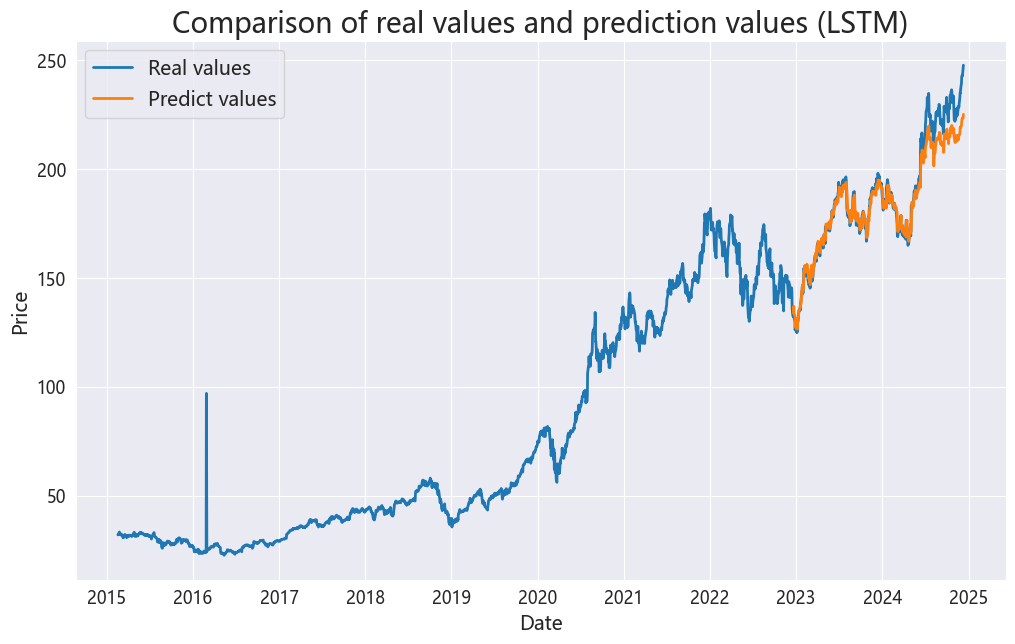

In [37]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(12, 7), dpi=100)  # 定义画布
ax.plot(
    date_train.tolist() + date_test.tolist(),
    y_train_of_lstm + y_test_of_lstm,
    marker="",
    linestyle="-",
    linewidth=2,
    label="Real values",
)  # 画真实值
ax.plot(date_test, y_test_pred_of_lstm, marker="", linestyle="-", linewidth=2, label="Predict values")  # 画预测值
ax.set_title("Comparison of real values and prediction values (LSTM)", fontsize=20)  # 标题
ax.set_xlabel("Date", fontsize=14)  # x轴标签
ax.set_ylabel("Price", fontsize=14)  # y轴标签
ax.tick_params(labelsize=12)  # 设置坐标轴轴刻度大小
ax.legend(loc="best", prop={"size": 14})  # 图例
plt.show()  # 显示图像
plt.close()  # 关闭图像

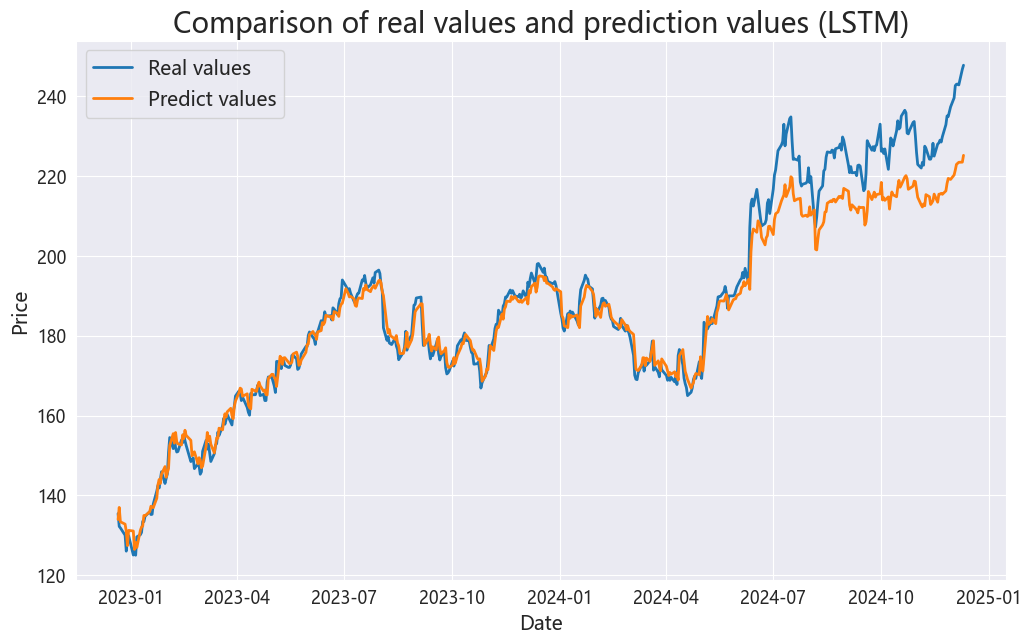

In [38]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(12, 7), dpi=100)  # 定义画布
ax.plot(date_test, y_test_of_lstm, marker="", linestyle="-", linewidth=2, label="Real values")  # 画真实值
ax.plot(date_test, y_test_pred_of_lstm, marker="", linestyle="-", linewidth=2, label="Predict values")  # 画预测值
ax.set_title("Comparison of real values and prediction values (LSTM)", fontsize=20)  # 标题
ax.set_xlabel("Date", fontsize=14)  # x轴标签
ax.set_ylabel("Price", fontsize=14)  # y轴标签
ax.tick_params(labelsize=12)  # 设置坐标轴轴刻度大小
ax.legend(loc="best", prop={"size": 14})  # 图例
plt.show()  # 显示图像
plt.close()  # 关闭图像

### GRU模型训练及评估
### GRU model training and evaluation

In [39]:
def setup_seed(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    os.environ["PYTHONHASHSEED"] = str(seed)

    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)

    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    torch.backends.cudnn.enabled = False

    os.environ["CUBLAS_WORKSPACE_CONFIG"] = ":16:8"

    torch.use_deterministic_algorithms(True)

setup_seed(seed=42)  # 设置随机种子

In [40]:
class Datasets(Dataset):
    def __init__(self, X, y):
        self.X = X
        self.y = y

    def __len__(self):
        assert len(self.X) == len(self.y)
        return len(self.y)

    def __getitem__(self, index):
        return torch.FloatTensor(self.X[index]), torch.FloatTensor(self.y[index])

In [41]:
class GRUModel(nn.Module):
    def __init__(self, inputs_size, outputs_size):
        super(GRUModel, self).__init__()
        self.up_dim = nn.Linear(inputs_size, 32)  # 升维层
        self.gru = nn.GRU(32, 128, num_layers=1, batch_first=True, dropout=0, bidirectional=False)  # GRU层
        self.predict = nn.Linear(128, outputs_size)  # 预测层
        self.activation = nn.PReLU()  # 激活层
        self.dropout = nn.Dropout(0.2)  # dropout层

    def gru_forward(self, inputs):  # torch.Size([B, W, 32])
        outputs, h_n = self.gru(inputs)  # torch.Size([B, W, 128])
        outputs = outputs[:, -1, :]  # torch.Size([B, 128])
        outputs = self.activation(outputs)  # torch.Size([B, 128])
        return outputs

    def forward(self, inputs):  # torch.Size([B, W, T])
        outputs = self.up_dim(inputs)  # torch.Size([B, W, 32])
        outputs = self.gru_forward(outputs)  # torch.Size([B, 128])

        outputs = self.dropout(outputs)  # torch.Size([B, 128])
        outputs = self.predict(outputs)  # torch.Size([B, 1])
        return outputs

In [42]:
batch_size = 128  # 批次大小
epochs = 200  # 训练轮数
learning_rate = 0.0003  # 学习率
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")  # 设备

print("Device:", device)  # 打印设备

Device: cuda


In [43]:
train_datasets = Datasets(X_train, y_train)  # 训练集
test_datasets = Datasets(X_test, y_test)  # 测试集

train_loader = DataLoader(train_datasets, batch_size=batch_size, shuffle=True, num_workers=0, drop_last=False)  # 训练集加载器
test_loader = DataLoader(test_datasets, batch_size=batch_size, shuffle=False, num_workers=0, drop_last=False)  # 测试集加载器

In [44]:
gru_model = GRUModel(inputs_size=X_train.shape[-1], outputs_size=1).to(device)  # 定义模型
optimizer = torch.optim.Adam(gru_model.parameters(), lr=learning_rate)  # 优化器
criterion = torch.nn.MSELoss()  # 损失函数

In [45]:
best_test_r2 = 0  # 最好的测试集R2
train_r2_records = []  # 训练集R2记录
train_loss_records = []  # 训练集Loss记录
test_r2_records = []  # 测试集R2记录
test_loss_records = []  # 测试集Loss记录
for epoch in range(1, epochs + 1):  # 循环每一个epoch
    gru_model.train()  # 训练模式
    train_real_targets = []  # 训练集真实值
    train_pred_targets = []  # 训练集预测值
    train_loss_logs = []  # 训练集Loss记录
    for inputs, targets in tqdm(train_loader, file=sys.stdout):  # 循环每一个batch
        outputs = gru_model(inputs.to(device))  # 前向传播
        loss = criterion(outputs, targets.to(device))  # 计算Loss
        optimizer.zero_grad()  # 梯度清零
        loss.backward()  # 反向传播
        optimizer.step()  # 更新参数
        train_real_targets.extend(targets.numpy().tolist())  # 记录真实值
        train_pred_targets.extend(outputs.detach().cpu().numpy().tolist())  # 记录预测值
        train_loss_logs.append(loss.item())  # 记录Loss
    train_r2 = round(r2_score(train_real_targets, train_pred_targets), 4)  # 计算R2
    train_loss = round(sum(train_loss_logs) / len(train_loss_logs), 4)  # 求loss均值
    print(f"Epoch: {epoch} / {epochs}, Train R2: {train_r2:.4f}, Train Loss: {train_loss:4f}")

    gru_model.eval()  # 测试模式
    test_real_targets = []  # 测试集真实值
    test_pred_targets = []  # 测试集预测值
    test_loss_logs = []  # 测试集Loss记录
    for inputs, targets in tqdm(test_loader, file=sys.stdout):  # 循环每一个batch
        outputs = gru_model(inputs.to(device))  # 前向传播
        loss = criterion(outputs, targets.to(device))  # 计算Loss
        test_real_targets.extend(targets.numpy().tolist())  # 记录真实值
        test_pred_targets.extend(outputs.detach().cpu().numpy().tolist())  # 记录预测值
        test_loss_logs.append(loss.item())  # 记录Loss
    test_r2 = round(r2_score(test_real_targets, test_pred_targets), 4)  # 计算R2
    test_loss = round(sum(test_loss_logs) / len(test_loss_logs), 4)  # 求loss均值
    print(f"Epoch: {epoch} / {epochs}, Test R2: {test_r2}, Test Loss: {test_loss}")

    if test_r2 > best_test_r2:  # 保存最好的模型
        best_test_r2 = test_r2  # 更新最好的测试集R2
        torch.save(gru_model.state_dict(), "gru_model.pt")  # 保存模型
    print(f"Best test r2: {best_test_r2:.4f}")

    train_r2_records.append(train_r2)  # 记录训练集R2
    train_loss_records.append(train_loss)  # 记录训练集Loss
    test_r2_records.append(test_r2)  # 记录测试集R2
    test_loss_records.append(test_loss)  # 记录测试集Loss

print("Done! Best test r2:", best_test_r2)

100%|██████████| 16/16 [00:00<00:00, 102.42it/s]
Epoch: 1 / 200, Train R2: 0.2896, Train Loss: 0.698800
100%|██████████| 4/4 [00:00<00:00, 346.82it/s]
Epoch: 1 / 200, Test R2: -7.7055, Test Loss: 2.6809
Best test r2: 0.0000
100%|██████████| 16/16 [00:00<00:00, 110.49it/s]
Epoch: 2 / 200, Train R2: 0.8351, Train Loss: 0.159900
100%|██████████| 4/4 [00:00<00:00, 266.68it/s]
Epoch: 2 / 200, Test R2: -0.4512, Test Loss: 0.4604
Best test r2: 0.0000
100%|██████████| 16/16 [00:00<00:00, 111.97it/s]
Epoch: 3 / 200, Train R2: 0.9699, Train Loss: 0.029500
100%|██████████| 4/4 [00:00<00:00, 363.51it/s]
Epoch: 3 / 200, Test R2: 0.2057, Test Loss: 0.2561
Best test r2: 0.2057
100%|██████████| 16/16 [00:00<00:00, 108.80it/s]
Epoch: 4 / 200, Train R2: 0.9838, Train Loss: 0.017100
100%|██████████| 4/4 [00:00<00:00, 266.38it/s]
Epoch: 4 / 200, Test R2: -0.1658, Test Loss: 0.371
Best test r2: 0.2057
100%|██████████| 16/16 [00:00<00:00, 115.49it/s]
Epoch: 5 / 200, Train R2: 0.9865, Train Loss: 0.013600
10

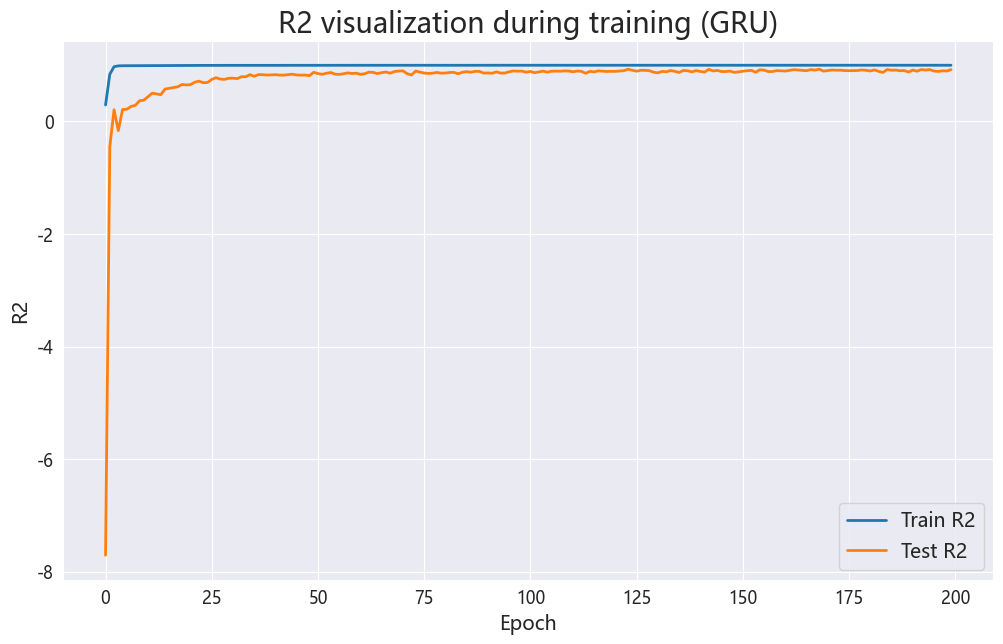

In [46]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(12, 7), dpi=100)  # 定义画布
ax.plot(train_r2_records, marker="", linestyle="-", linewidth=2, label="Train R2")  # 画训练集R2曲线
ax.plot(test_r2_records, marker="", linestyle="-", linewidth=2, label="Test R2")  # 画测试集R2曲线
ax.set_title("R2 visualization during training (GRU)", fontsize=20)  # 标题
ax.set_xlabel("Epoch", fontsize=14)  # x轴标签
ax.set_ylabel("R2", fontsize=14)  # y轴标签
ax.tick_params(labelsize=12)  # 设置坐标轴轴刻度大小
ax.legend(loc="best", prop={"size": 14})  # 图例
plt.show()  # 显示图像
plt.close()  # 关闭图像

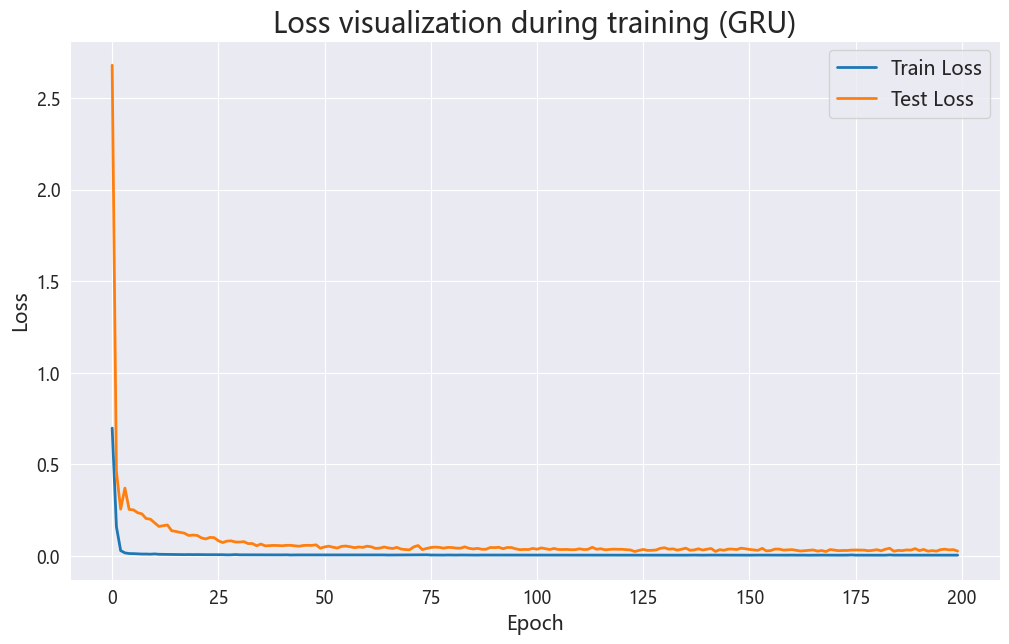

In [47]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(12, 7), dpi=100)  # 定义画布
ax.plot(train_loss_records, marker="", linestyle="-", linewidth=2, label="Train Loss")  # 画训练集Loss曲线
ax.plot(test_loss_records, marker="", linestyle="-", linewidth=2, label="Test Loss")  # 画测试集Loss曲线
ax.set_title("Loss visualization during training (GRU)", fontsize=20)  # 标题
ax.set_xlabel("Epoch", fontsize=14)  # x轴标签
ax.set_ylabel("Loss", fontsize=14)  # y轴标签
ax.tick_params(labelsize=12)  # 设置坐标轴轴刻度大小
ax.legend(loc="best", prop={"size": 14})  # 图例
plt.show()  # 显示图像
plt.close()  # 关闭图像

In [48]:
gru_model = GRUModel(inputs_size=X_train.shape[-1], outputs_size=1).to(device)  # 定义模型
gru_model.load_state_dict(torch.load("gru_model.pt"))  # 加载模型
gru_model.eval()  # 测试模式

y_test_pred_of_gru = []  # 测试集预测值
for inputs, targets in tqdm(test_loader, file=sys.stdout):  # 循环每一个batch
    outputs = gru_model(inputs.to(device))  # 前向传播
    y_test_pred_of_gru.extend(outputs.detach().cpu().numpy().tolist())  # 记录预测值

y_train_of_gru = y_scaler.inverse_transform(y_train.reshape(-1, 1)).reshape(-1).tolist()  # 反标准化
y_test_of_gru = y_scaler.inverse_transform(y_test.reshape(-1, 1)).reshape(-1).tolist()  # 反标准化
y_test_pred_of_gru = y_scaler.inverse_transform(y_test_pred_of_gru).reshape(-1).tolist()  # 反标准化

print("GRU Model:")
print(f"MAE: {mean_absolute_error(y_test_of_gru, y_test_pred_of_gru)}")  # 平均绝对误差
print(f"MSE: {mean_squared_error(y_test_of_gru, y_test_pred_of_gru)}")  # 均方误差
print(f"RMSE: {mean_squared_error(y_test_of_gru, y_test_pred_of_gru, squared=False)}")  # 均方根误差
print(f"R2: {r2_score(y_test_of_gru, y_test_pred_of_gru)}")  # R2

100%|██████████| 4/4 [00:00<00:00, 307.70it/s]
GRU Model:
MAE: 4.971762273749362
MSE: 53.82185618948175
RMSE: 7.336338064012709
R2: 0.9250916222174549


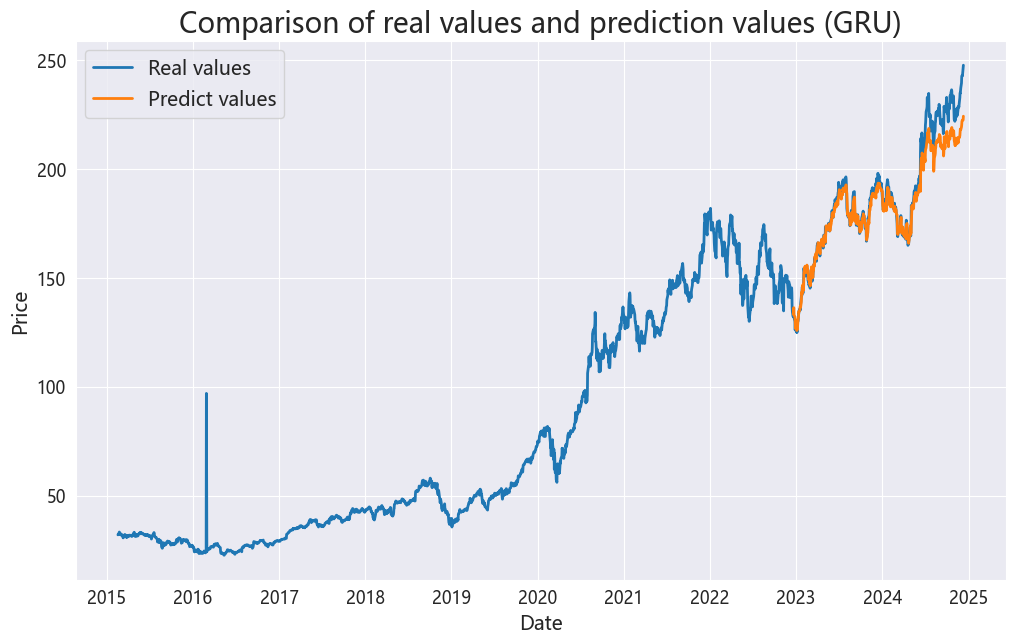

In [49]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(12, 7), dpi=100)  # 定义画布
ax.plot(
    date_train.tolist() + date_test.tolist(),
    y_train_of_gru + y_test_of_gru,
    marker="",
    linestyle="-",
    linewidth=2,
    label="Real values",
)  # 画真实值
ax.plot(date_test, y_test_pred_of_gru, marker="", linestyle="-", linewidth=2, label="Predict values")  # 画预测值
ax.set_title("Comparison of real values and prediction values (GRU)", fontsize=20)  # 标题
ax.set_xlabel("Date", fontsize=14)  # x轴标签
ax.set_ylabel("Price", fontsize=14)  # y轴标签
ax.tick_params(labelsize=12)  # 设置坐标轴轴刻度大小
ax.legend(loc="best", prop={"size": 14})  # 图例
plt.show()  # 显示图像
plt.close()  # 关闭图像

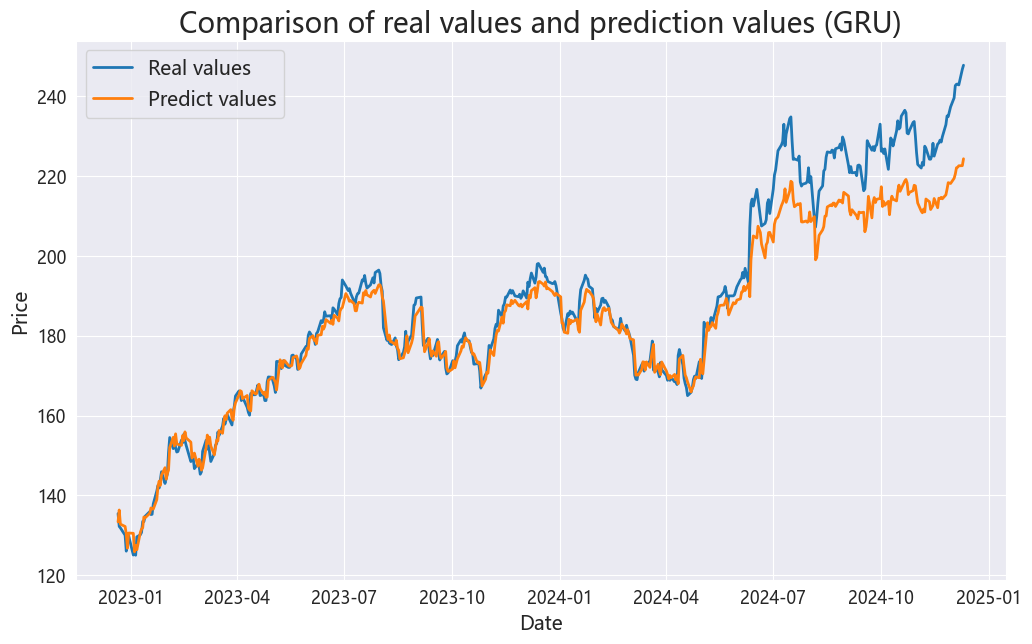

In [50]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(12, 7), dpi=100)  # 定义画布
ax.plot(date_test, y_test_of_gru, marker="", linestyle="-", linewidth=2, label="Real values")  # 画真实值
ax.plot(date_test, y_test_pred_of_gru, marker="", linestyle="-", linewidth=2, label="Predict values")  # 画预测值
ax.set_title("Comparison of real values and prediction values (GRU)", fontsize=20)  # 标题
ax.set_xlabel("Date", fontsize=14)  # x轴标签
ax.set_ylabel("Price", fontsize=14)  # y轴标签
ax.tick_params(labelsize=12)  # 设置坐标轴轴刻度大小
ax.legend(loc="best", prop={"size": 14})  # 图例
plt.show()  # 显示图像
plt.close()  # 关闭图像

### 模型对比
### Model comparison

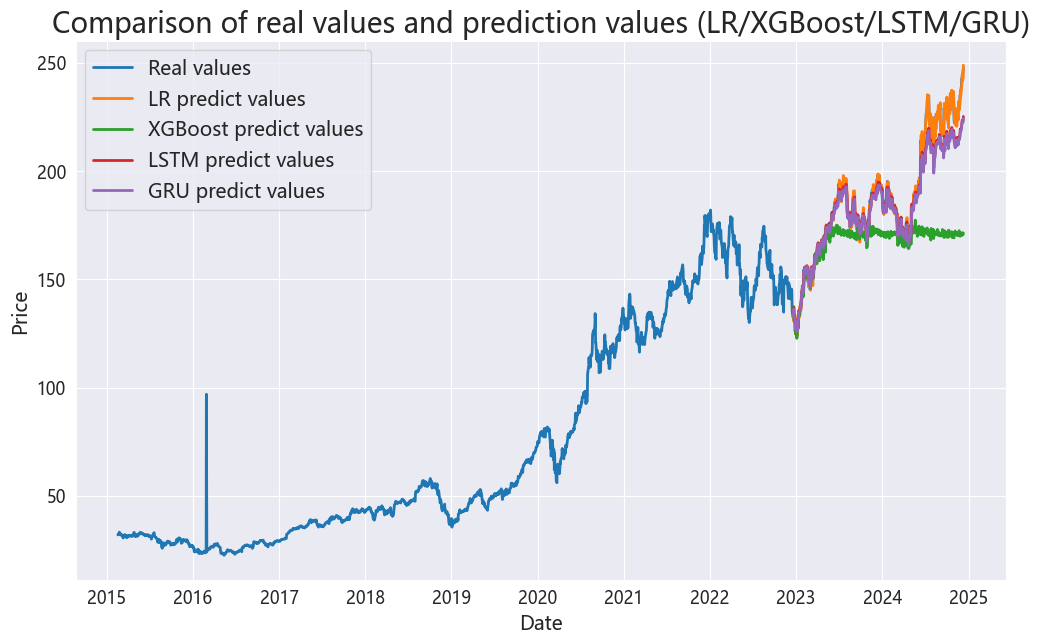

In [51]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(12, 7), dpi=100)  # 定义画布
ax.plot(
    date_train.tolist() + date_test.tolist(),
    y_train_of_gru + y_test_of_gru,
    marker="",
    linestyle="-",
    linewidth=2,
    label="Real values",
)  # 画真实值
ax.plot(date_test, y_test_pred_of_lr, marker="", linestyle="-", linewidth=2, label="LR predict values")  # 画预测值
ax.plot(date_test, y_test_pred_of_xgb, marker="", linestyle="-", linewidth=2, label="XGBoost predict values")  # 画预测值
ax.plot(date_test, y_test_pred_of_lstm, marker="", linestyle="-", linewidth=2, label="LSTM predict values")  # 画预测值
ax.plot(date_test, y_test_pred_of_gru, marker="", linestyle="-", linewidth=2, label="GRU predict values")  # 画预测值
ax.set_title("Comparison of real values and prediction values (LR/XGBoost/LSTM/GRU)", fontsize=20)  # 标题
ax.set_xlabel("Date", fontsize=14)  # x轴标签
ax.set_ylabel("Price", fontsize=14)  # y轴标签
ax.tick_params(labelsize=12)  # 设置坐标轴轴刻度大小
ax.legend(loc="best", prop={"size": 14})  # 图例
plt.show()  # 显示图像
plt.close()  # 关闭图像

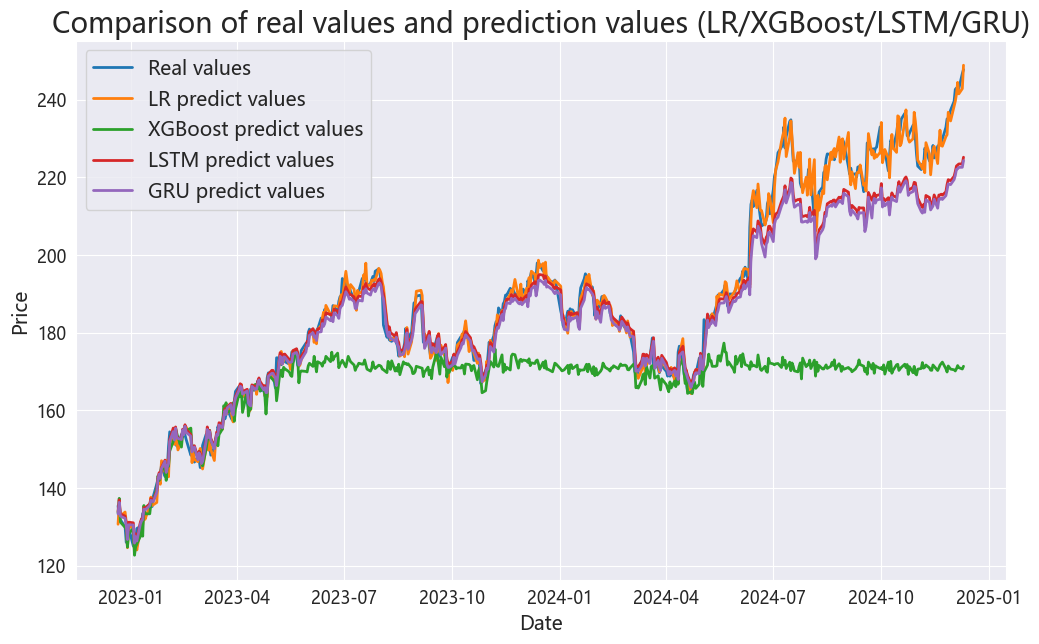

In [52]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(12, 7), dpi=100)  # 定义画布
ax.plot(date_test, y_test_of_gru, marker="", linestyle="-", linewidth=2, label="Real values")  # 画真实值
ax.plot(date_test, y_test_pred_of_lr, marker="", linestyle="-", linewidth=2, label="LR predict values")  # 画预测值
ax.plot(date_test, y_test_pred_of_xgb, marker="", linestyle="-", linewidth=2, label="XGBoost predict values")  # 画预测值
ax.plot(date_test, y_test_pred_of_lstm, marker="", linestyle="-", linewidth=2, label="LSTM predict values")  # 画预测值
ax.plot(date_test, y_test_pred_of_gru, marker="", linestyle="-", linewidth=2, label="GRU predict values")  # 画预测值
ax.set_title("Comparison of real values and prediction values (LR/XGBoost/LSTM/GRU)", fontsize=20)  # 标题
ax.set_xlabel("Date", fontsize=14)  # x轴标签
ax.set_ylabel("Price", fontsize=14)  # y轴标签
ax.tick_params(labelsize=12)  # 设置坐标轴轴刻度大小
ax.legend(loc="best", prop={"size": 14})  # 图例
plt.show()  # 显示图像
plt.close()  # 关闭图像

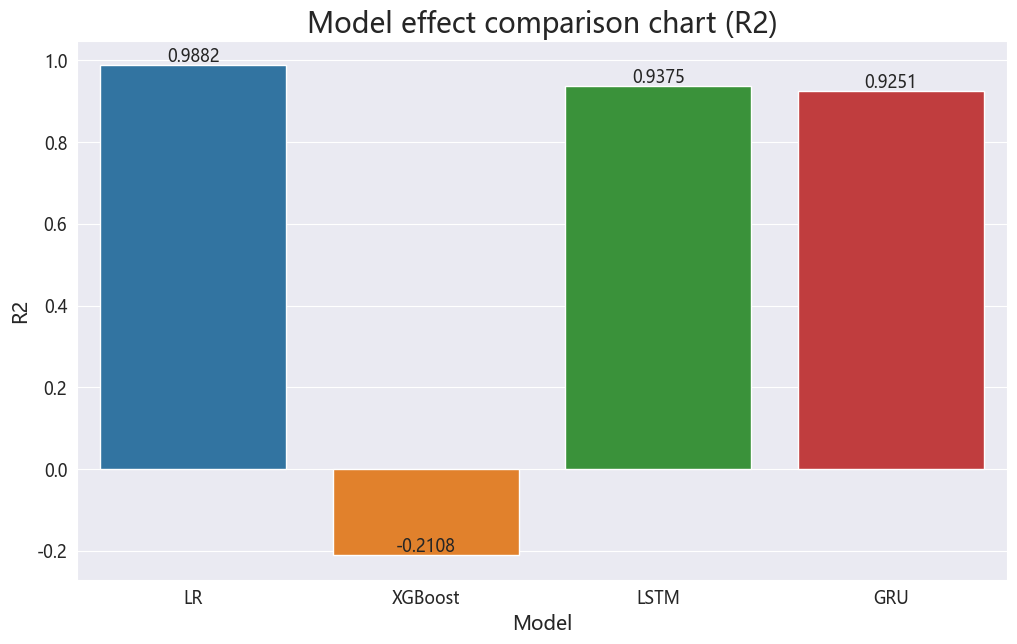

In [53]:
models = ["LR", "XGBoost", "LSTM", "GRU"]  # 模型名称
r2s = [
    r2_score(y_test_of_lr, y_test_pred_of_lr),
    r2_score(y_test_of_xgb, y_test_pred_of_xgb),
    r2_score(y_test_of_lstm, y_test_pred_of_lstm),
    r2_score(y_test_of_gru, y_test_pred_of_gru),
]  # 准确率

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(12, 7), dpi=100)  # 定义画布
sns.barplot(x=models, y=r2s, ax=ax)  # 画条形图
for x, y in zip(range(len(models)), [round(item, 4) for item in r2s]):  # 遍历所有特征
    ax.text(x=x, y=y, s=round(y, 4), ha="center", va="bottom", fontdict={"size": 12})  # 在条形图上显示数字
ax.set_title("Model effect comparison chart (R2)", fontsize=20)  # 标题
ax.set_xlabel("Model", fontsize=14)  # x轴标签
ax.set_ylabel("R2", fontsize=14)  # y轴标签
ax.tick_params(labelsize=12)  # 设置坐标轴轴刻度大小
plt.show()  # 显示图像
plt.close()  # 关闭图像

## S&P500期货价格与Apple股票价格的关系
## S&P500 futures price vs. Apple stock price

In [54]:
sp500_data = pd.read_csv("S&P 500 Futures Historical Data.csv")  # 加载数据
sp500_data["Date"] = pd.to_datetime(sp500_data["Date"])  # 转换日期格式
sp500_data["Price"] = sp500_data["Price"].apply(lambda x: float(str(x).replace(",", "")))  # 转换价格格式
sp500_data["Open"] = sp500_data["Open"].apply(lambda x: float(str(x).replace(",", "")))  # 转换开盘价格式
sp500_data["High"] = sp500_data["High"].apply(lambda x: float(str(x).replace(",", "")))  # 转换最高价格式
sp500_data["Low"] = sp500_data["Low"].apply(lambda x: float(str(x).replace(",", "")))  # 转换最低价格式
sp500_data["Vol."] = sp500_data["Vol."].apply(
    lambda x: float(str(x).replace("K", "")) * 1000 if "K" in str(x) else float(str(x).replace("M", "")) * 1000000
)  # 转换成交量格式
sp500_data["Vol."] = sp500_data["Vol."] / 1000000  # 转换成交量单位
sp500_data["Change %"] = sp500_data["Change %"].apply(lambda x: float(x.replace("%", "")))  # 转换涨跌幅格式
sp500_data = sp500_data.sort_values(by="Date").reset_index(drop=True)  # 按照日期排序
sp500_data = sp500_data.fillna(method="ffill").fillna(method="bfill")  # 填充缺失值

sp500_data

,Date,Price,Open,High,Low,Vol.,Change %
0,2015-01-01,2058.95,2051.65,2059.15,2051.65,1.36000,0.31
1,2015-01-02,2046.25,2055.00,2067.25,2038.75,1.36000,-0.62
2,2015-01-05,2016.00,2045.75,2048.25,2009.50,2.03000,-1.48
3,2015-01-06,1994.50,2019.00,2023.50,1984.25,2.35000,-1.07
4,2015-01-07,2019.50,1996.50,2023.75,1995.75,1.76000,1.25
...,...,...,...,...,...,...,...
2637,2024-12-04,6098.50,6067.00,6102.25,6063.00,1.14000,0.58
2638,2024-12-05,6088.75,6095.25,6107.25,6081.50,1.12000,-0.16
2639,2024-12-06,6099.00,6085.50,6111.00,6076.00,1.17000,0.17
2640,2024-12-09,6133.25,6164.25,6173.50,6127.50,0.04015,0.56


In [55]:
apple_data = pd.read_csv("Apple Stock Price History.csv")  # 加载数据
apple_data["Date"] = pd.to_datetime(apple_data["Date"])  # 转换日期格式
apple_data["Price"] = apple_data["Price"].apply(lambda x: float(str(x).replace(",", "")))  # 转换价格格式
apple_data["Open"] = apple_data["Open"].apply(lambda x: float(str(x).replace(",", "")))  # 转换开盘价格式
apple_data["High"] = apple_data["High"].apply(lambda x: float(str(x).replace(",", "")))  # 转换最高价格式
apple_data["Low"] = apple_data["Low"].apply(lambda x: float(str(x).replace(",", "")))  # 转换最低价格式
apple_data["Vol."] = apple_data["Vol."].apply(
    lambda x: float(str(x).replace("K", "")) * 1000 if "K" in str(x) else float(str(x).replace("M", "")) * 1000000
)  # 转换成交量格式
apple_data["Vol."] = apple_data["Vol."] / 1000000  # 转换成交量单位
apple_data["Change %"] = apple_data["Change %"].apply(lambda x: float(x.replace("%", "")))  # 转换涨跌幅格式
apple_data = apple_data.sort_values(by="Date").reset_index(drop=True)  # 按照日期排序
apple_data = apple_data.fillna(method="ffill").fillna(method="bfill")  # 填充缺失值

apple_data

,Date,Price,Open,High,Low,Vol.,Change %
0,2015-01-02,27.33,27.85,27.86,26.84,212.82,-0.94
1,2015-01-05,26.56,27.07,27.16,26.35,257.14,-2.82
2,2015-01-06,26.57,26.64,26.86,26.16,263.19,0.04
3,2015-01-07,26.94,26.80,27.05,26.67,160.42,1.39
4,2015-01-08,27.97,27.31,28.04,27.18,237.46,3.82
...,...,...,...,...,...,...,...
2498,2024-12-04,243.01,242.87,244.11,241.25,44.38,0.15
2499,2024-12-05,243.04,243.99,244.54,242.13,40.03,0.01
2500,2024-12-06,242.84,242.90,244.63,242.08,36.87,-0.08
2501,2024-12-09,246.75,241.83,247.24,241.75,44.65,1.61


以双y轴形式绘制S&P500期货价格和Apple股票价格的变化趋势。

Trends in S&P500 futures prices and Apple stock prices are plotted on a double y-axis.

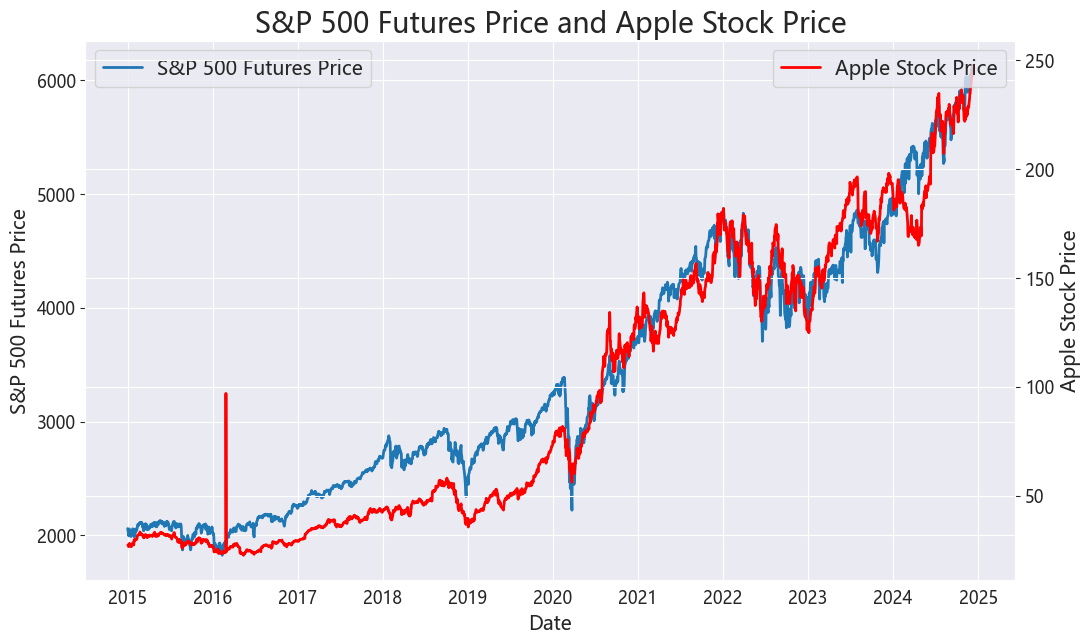

In [56]:
fig, ax1 = plt.subplots(nrows=1, ncols=1, figsize=(12, 7), dpi=100)  # 定义画布
ax2 = ax1.twinx()  # 创建第二个坐标轴
ax1.plot(sp500_data["Date"], sp500_data["Price"], marker="", linestyle="-", linewidth=2, label="S&P 500 Futures Price")  # 画S&P500期货价格
ax2.plot(apple_data["Date"], apple_data["Price"], marker="", linestyle="-", linewidth=2, label="Apple Stock Price", color="red")  # 画苹果股票价格
ax1.set_title("S&P 500 Futures Price and Apple Stock Price", fontsize=20)  # 标题
ax1.set_xlabel("Date", fontsize=14)  # x轴标签
ax1.set_ylabel("S&P 500 Futures Price", fontsize=14)  # y轴标签
ax2.set_ylabel("Apple Stock Price", fontsize=14)  # y轴标签
ax1.tick_params(labelsize=12)  # 设置坐标轴轴刻度大小
ax2.tick_params(labelsize=12)  # 设置坐标轴轴刻度大小
ax1.legend(loc="upper left", prop={"size": 14})  # 图例
ax2.legend(loc="upper right", prop={"size": 14})  # 图例
plt.show()  # 显示图像
plt.close()  # 关闭图像

合并涨跌率数据，绘制S&P500期货价格和Apple股票价格的涨跌率变化趋势。

Combine the rate-of-rise and rate-of-fall data to plot trends in the rate-of-rise and rate-of-fall of the S&P500 futures price and the Apple stock price.

In [57]:
change_data = pd.merge(sp500_data[["Date", "Change %"]], apple_data[["Date", "Change %"]], on="Date", how="inner")  # 合并数据
change_data = change_data.dropna().reset_index(drop=True)  # 删除缺失值
change_data.columns = ["Date", "SP500 Change %", "Apple Change %"]  # 重命名列

change_data

,Date,SP500 Change %,Apple Change %
0,2015-01-02,-0.62,-0.94
1,2015-01-05,-1.48,-2.82
2,2015-01-06,-1.07,0.04
3,2015-01-07,1.25,1.39
4,2015-01-08,1.76,3.82
...,...,...,...
2497,2024-12-04,0.58,0.15
2498,2024-12-05,-0.16,0.01
2499,2024-12-06,0.17,-0.08
2500,2024-12-09,0.56,1.61


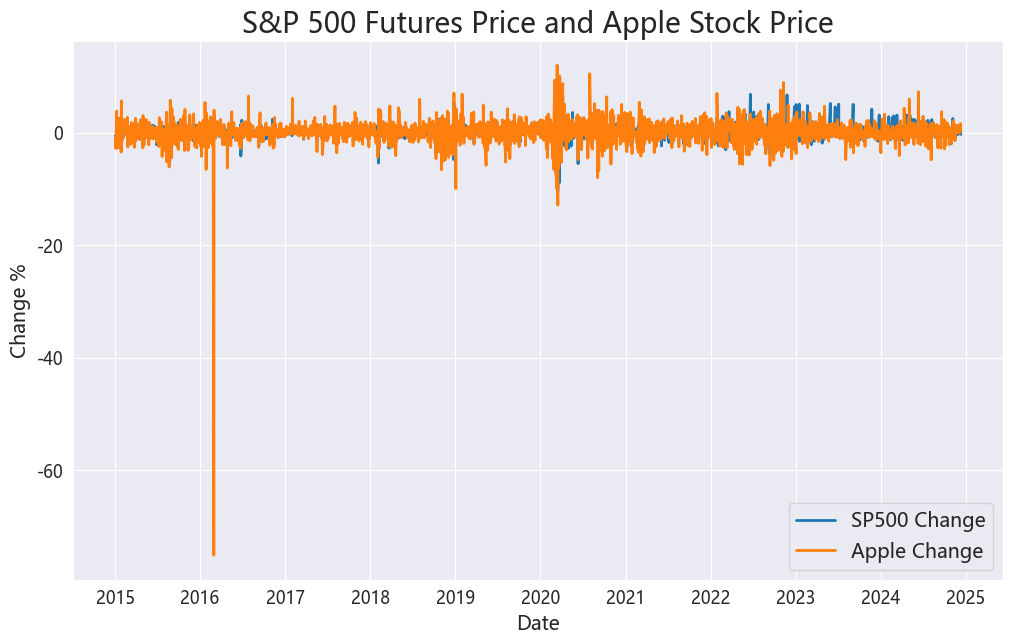

In [58]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(12, 7), dpi=100)  # 定义画布
ax.plot(change_data["Date"].tolist(), change_data["SP500 Change %"].tolist(), marker="", linestyle="-", linewidth=2, label="SP500 Change")  # 画SP500涨跌率
ax.plot(change_data["Date"].tolist(), change_data["Apple Change %"].tolist(), marker="", linestyle="-", linewidth=2, label="Apple Change")  # 画Apple涨跌率
ax.set_title("S&P 500 Futures Price and Apple Stock Price", fontsize=20)  # 标题
ax.set_xlabel("Date", fontsize=14)  # x轴标签
ax.set_ylabel("Change %", fontsize=14)  # y轴标签
ax.tick_params(labelsize=12)  # 设置坐标轴轴刻度大小
ax.legend(loc="best", prop={"size": 14})  # 图例
plt.show()  # 展示图像
plt.close()  # 关闭图像

绘制S&P500期货价格和Apple股票价格的散点图，并拟合线性回归模型，进一步分析两者之间的关系。

Scatter plots of S&P500 futures prices and Apple stock prices were plotted and linear regression models were fitted to further analyze the relationship.

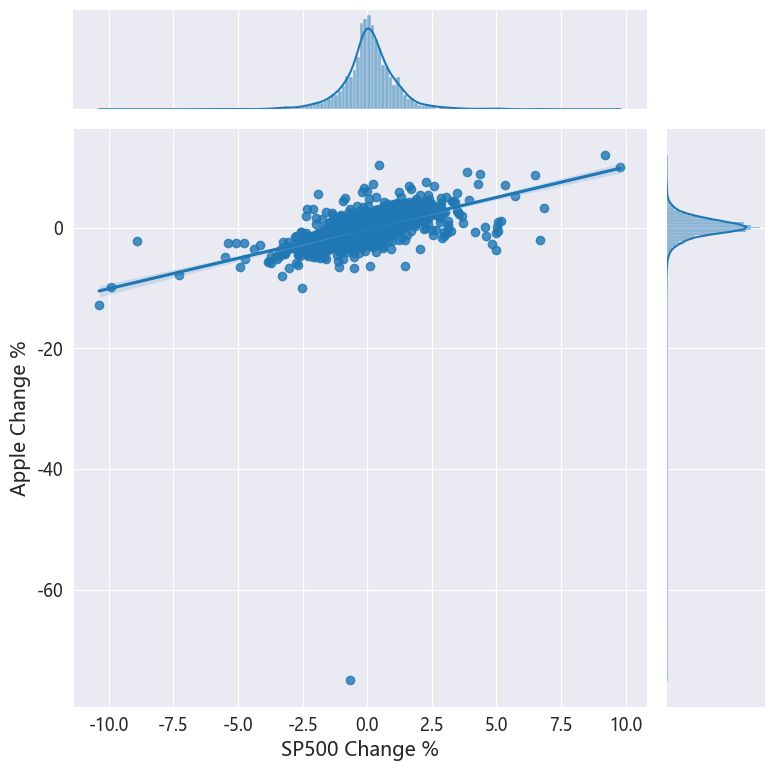

In [59]:
g = sns.jointplot(data=change_data, x="SP500 Change %", y="Apple Change %", kind="reg")  # 绘制SP500涨跌率和Apple涨跌率的关系图
g.fig.set_figheight(8)  # 设置图像高度
g.fig.set_figwidth(8)  # 设置图像宽度
# g.fig.suptitle("S&P 500 Futures Price and Apple Stock Price", fontsize=20)  # 设置标题
g.set_axis_labels("SP500 Change %", "Apple Change %", fontsize=14)  # 设置坐标轴标签
g.ax_joint.tick_params(labelsize=12)  # 设置坐标轴轴刻度大小
plt.show()  # 展示图像
plt.close()  # 关闭图像

In [60]:
X = change_data["SP500 Change %"].values.reshape(-1, 1)  # 特征
y = change_data["Apple Change %"].values  # 标签
model = LinearRegression()  # 定义模型
model.fit(X, y)  # 拟合模型
print("LR Model coefficient:", model.coef_.item())  # 系数

LR Model coefficient: 1.0087656460363885


上述结果表明，S&P500期货价格和Apple股票价格的涨跌率之间存在一定的线性关系，且系数为1.0，说明两者之间存在正相关关系。

进一步的，使用皮尔逊相关系数来衡量两者之间的相关性。

The above results show that there is a linear relationship between the S&P500 futures price and the rate of increase or decrease in the Apple stock price with a coefficient of 1.0, indicating a positive correlation between the two.

Further, the Pearson correlation coefficient is used to measure the correlation between the two.

In [61]:
correlation = change_data["SP500 Change %"].corr(change_data["Apple Change %"])  # 计算相关系数
print("Correlation:", correlation)  # 相关系数

Correlation: 0.5132117858670093


In [62]:
for i in range(1, 11):  # 循环1-10
    change_data[f"SP500 Change % +{i}"] = change_data["SP500 Change %"].shift(i)  # 滞后
    change_data[f"Apple Change % +{i}"] = change_data["Apple Change %"].shift(i)  # 滞后

change_data

,Date,SP500 Change %,Apple Change %,SP500 Change % +1,Apple Change % +1,SP500 Change % +2,Apple Change % +2,SP500 Change % +3,Apple Change % +3,SP500 Change % +4,...,SP500 Change % +6,Apple Change % +6,SP500 Change % +7,Apple Change % +7,SP500 Change % +8,Apple Change % +8,SP500 Change % +9,Apple Change % +9,SP500 Change % +10,Apple Change % +10
0,2015-01-02,-0.62,-0.94,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2015-01-05,-1.48,-2.82,-0.62,-0.94,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2015-01-06,-1.07,0.04,-1.48,-2.82,-0.62,-0.94,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2015-01-07,1.25,1.39,-1.07,0.04,-1.48,-2.82,-0.62,-0.94,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2015-01-08,1.76,3.82,1.25,1.39,-1.07,0.04,-1.48,-2.82,-0.62,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2497,2024-12-04,0.58,0.15,0.02,1.28,0.17,0.95,0.61,1.02,-0.39,...,0.33,1.31,0.28,0.59,0.55,-0.21,-0.02,0.32,0.32,0.11
2498,2024-12-05,-0.16,0.01,0.58,0.15,0.02,1.28,0.17,0.95,0.61,...,0.53,0.94,0.33,1.31,0.28,0.59,0.55,-0.21,-0.02,0.32
2499,2024-12-06,0.17,-0.08,-0.16,0.01,0.58,0.15,0.02,1.28,0.17,...,-0.39,-0.06,0.53,0.94,0.33,1.31,0.28,0.59,0.55,-0.21
2500,2024-12-09,0.56,1.61,0.17,-0.08,-0.16,0.01,0.58,0.15,0.02,...,0.61,1.02,-0.39,-0.06,0.53,0.94,0.33,1.31,0.28,0.59


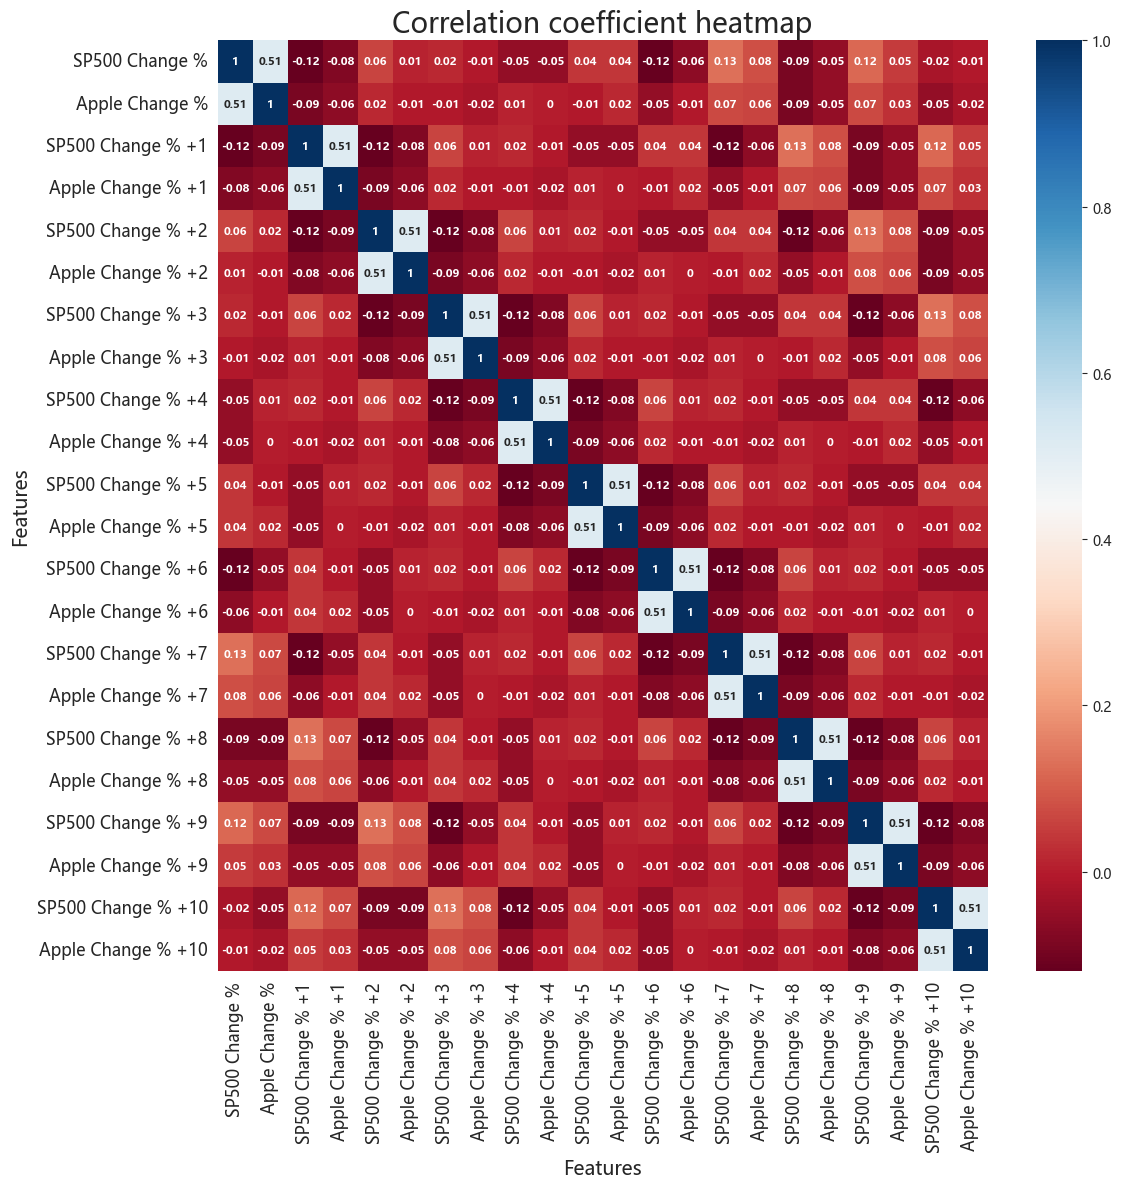

In [63]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(12, 12), dpi=100)  # 定义画布
sns.heatmap(
    change_data.drop(columns=["Date"]).corr().round(2),
    annot=True,
    fmt=".2g",
    cmap="RdBu",  # Blues
    annot_kws={"size": 8, "weight": "bold"},
    ax=ax,
)  # 绘制相关性图
ax.set_title("Correlation coefficient heatmap", fontsize=20)  # 标题
ax.set_xlabel("Features", fontsize=14)  # x轴标签
ax.set_ylabel("Features", fontsize=14)  # y轴标签
ax.tick_params(labelsize=12)  # 设置坐标轴轴刻度大小
plt.tight_layout()  # 防重叠
plt.show()  # 显示图像
plt.close()  # 关闭图像

上述结果表明，S&P500期货价格和Apple股票价格的涨跌率之间存在一定的相关性，但是相关性并不是很强。

The above results indicate that there is some correlation between the S&P500 futures price and the rate of increase or decrease in Apple's stock price, but the correlation is not very strong.

为进一步挖掘S&P500期货价格和Apple股票价格变化（涨跌率）之间的关系，可以使用Granger因果检验来检验两者之间是否存在因果关系。

To further explore the relationship between S&P500 futures prices and Apple stock price changes (rate of increase or decrease), the Granger causality test can be used to test whether there is a causal relationship between the two.

In [64]:
granger_test = grangercausalitytests(change_data[["SP500 Change %", "Apple Change %"]], maxlag=10, verbose=True, addconst=True)  # Granger因果检验


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.5726  , p=0.4493  , df_denom=2498, df_num=1
ssr based chi2 test:   chi2=0.5733  , p=0.4490  , df=1
likelihood ratio test: chi2=0.5732  , p=0.4490  , df=1
parameter F test:         F=0.5726  , p=0.4493  , df_denom=2498, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=1.3587  , p=0.2572  , df_denom=2495, df_num=2
ssr based chi2 test:   chi2=2.7228  , p=0.2563  , df=2
likelihood ratio test: chi2=2.7213  , p=0.2565  , df=2
parameter F test:         F=1.3587  , p=0.2572  , df_denom=2495, df_num=2

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=1.6585  , p=0.1739  , df_denom=2492, df_num=3
ssr based chi2 test:   chi2=4.9894  , p=0.1726  , df=3
likelihood ratio test: chi2=4.9844  , p=0.1729  , df=3
parameter F test:         F=1.6585  , p=0.1739  , df_denom=2492, df_num=3

Granger Causality
number of lags (no zero) 4
ssr based F test:         F=2.0150  , p=0.

上述结果表明，当最大滞后阶数为4时，S&P500期货价格对Apple股票价格的涨跌率具有一定的因果关系（注意，只是有一定的因果关系，并不显著。），此时的p值为0.08。（真正情况下是当p值小于0.05时具有显著因果关系，但是滞后点1-10之间只有4时p值是最小的。）

The above results show that the S&P500 futures price has some causality on the rate of increase or decrease of Apple's stock price when the maximum lag order is 4. (Note that there is only some causality, not significant.) , at which point the p-value is 0.08. (The real case is when the p-value is less than 0.05 has a significant causal relationship, but the lag point between 1-10 is only 4 when the p-value is the smallest.)